In [2]:
%reload_ext autoreload
%autoreload 2

import os

os.chdir(f"/home/{os.getlogin()}/watttime-python-client-aer-algo")

import math
import numpy as np
import pandas as pd
import datetime
from pytz import UTC, timezone
import seaborn as sns
from datetime import datetime, timedelta
import concurrent.futures
import contextlib
import io

from watttime import WattTimeForecast, WattTimeHistorical, RecalculatingWattTimeOptimizer

import data.s3 as s3u
import evaluation.eval_framework as efu
from plotnine import *

username = os.getenv("WATTTIME_USER")
password = os.getenv("WATTTIME_PASSWORD")

actual_data = WattTimeHistorical(username, password)
hist_data = WattTimeForecast(username, password)

s3 = s3u.s3_utils()
pd.options.mode.chained_assignment = None  # default='warn'
import random
from tqdm import tqdm
import warnings

In [5]:
requery_results = s3.load_parquetdataframe(f"historical_requery_sim_1000_simple_fit.parquet").drop_duplicates()
requery_results.head(3)

point_time  actual_moer  usage  emissions_co2e_lb  \
0 2023-03-24 12:25:00+00:00        984.0    0.0                0.0   
1 2023-03-24 12:30:00+00:00        985.0    0.0                0.0   
2 2023-03-24 12:35:00+00:00        986.0    0.0                0.0   

   energy_usage_mwh increment  pred_moer  actual_emissions  \
0               0.0     Ideal      984.0               0.0   
1               0.0     Ideal      985.0               0.0   
2               0.0     Ideal      986.0               0.0   

                  init_time       region  
0 2023-03-24 12:29:40+00:00  CAISO_NORTH  
1 2023-03-24 12:29:40+00:00  CAISO_NORTH  
2 2023-03-24 12:29:40+00:00  CAISO_NORTH

In [6]:
totals = requery_results.groupby(["increment", "region", "init_time"])[["actual_emissions", "emissions_co2e_lb"]].sum().reset_index()
totals.head(3)

/tmp/ipykernel_1758382/946322773.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


increment       region                 init_time  actual_emissions  \
0     Ideal  CAISO_NORTH 2023-01-01 02:57:27+00:00          5.706667   
1     Ideal  CAISO_NORTH 2023-01-01 13:39:42+00:00          5.913667   
2     Ideal  CAISO_NORTH 2023-01-01 15:46:29+00:00          5.952167   

   emissions_co2e_lb  
0           5.706667  
1           5.913667  
2           5.952167

In [7]:
ideals = totals.query("increment == 'Ideal'")[["init_time", "region", "actual_emissions"]].rename({"actual_emissions" : "ideal_emissions"}, axis =1)
baselines = totals.query("increment == 'Baseline'")[["init_time", "region", "actual_emissions"]].rename({"actual_emissions" : "baseline_emissions"}, axis =1)
no_reqs = totals.query("increment == 'No requery'")[["init_time", "region", "actual_emissions"]].rename({"actual_emissions" : "no_requery_emissions"}, axis =1)

In [8]:
totals_comp = totals.merge(ideals).merge(baselines).merge(no_reqs)

In [9]:
totals_comp["ideal_diff_pct"] = (totals_comp['actual_emissions'] - totals_comp["ideal_emissions"]) / totals_comp["ideal_emissions"] * 100
totals_comp["baseline_diff_pct"] = -(totals_comp['actual_emissions'] - totals_comp["baseline_emissions"]) / totals_comp["baseline_emissions"] * 100
totals_comp["ideal_diff"] = (totals_comp['actual_emissions'] - totals_comp["ideal_emissions"])
totals_comp["baseline_diff"] = -(totals_comp['actual_emissions'] - totals_comp["baseline_emissions"])
totals_comp["no_requery_diff_pct"] = -(totals_comp['actual_emissions'] - totals_comp["no_requery_emissions"]) / totals_comp["no_requery_emissions"] * 100
totals_comp["no_requery_diff"] = (totals_comp['actual_emissions'] - totals_comp["no_requery_emissions"])

In [10]:
totals_comp.head(3)

increment       region                 init_time  actual_emissions  \
0     Ideal  CAISO_NORTH 2023-01-01 02:57:27+00:00          5.706667   
1     Ideal  CAISO_NORTH 2023-01-01 13:39:42+00:00          5.913667   
2     Ideal  CAISO_NORTH 2023-01-01 15:46:29+00:00          5.952167   

   emissions_co2e_lb  ideal_emissions  baseline_emissions  \
0           5.706667         5.706667            5.821667   
1           5.913667         5.913667            6.295667   
2           5.952167         5.952167            6.435333   

   no_requery_emissions  ideal_diff_pct  baseline_diff_pct  ideal_diff  \
0              5.740500             0.0           1.975379         0.0   
1              6.013333             0.0           6.067666         0.0   
2              6.013333             0.0           7.508029         0.0   

   baseline_diff  no_requery_diff_pct  no_requery_diff  
0       0.115000             0.589380        -0.033833  
1       0.382000             1.657428        -0.099667  
2       0.483167             1.017184        -0.061167

In [11]:
plot_dat = totals_comp.groupby(["region", "increment"])[["ideal_diff_pct", "baseline_diff_pct", "ideal_diff", "baseline_diff", "no_requery_diff_pct", "no_requery_diff"]].mean().reset_index()

/tmp/ipykernel_1758382/1119931007.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


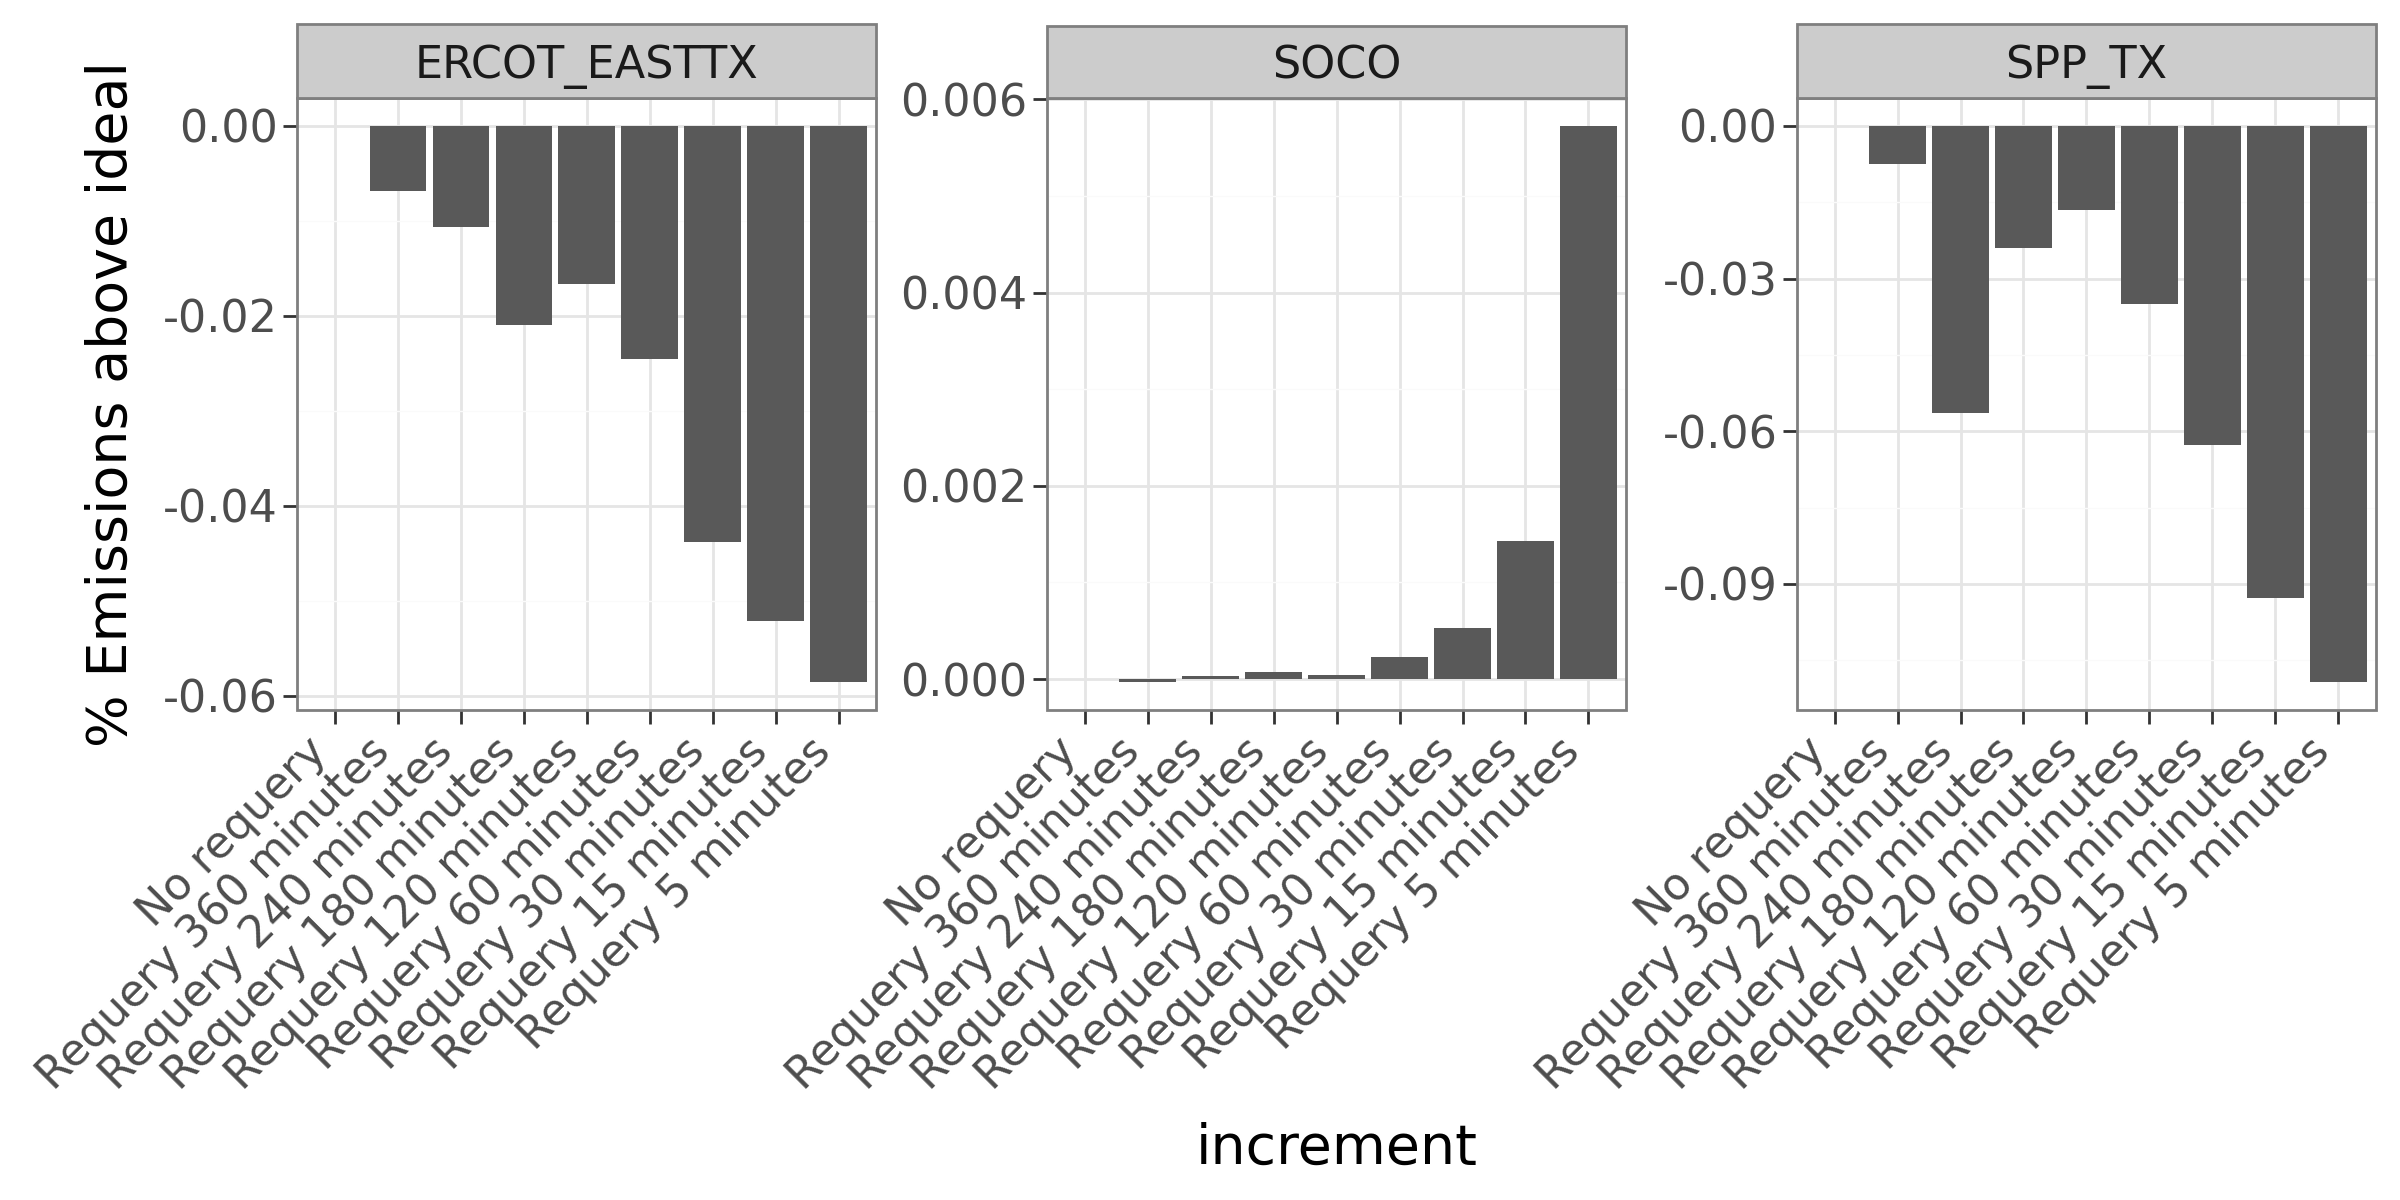

In [12]:
(ggplot(plot_dat.query("region.isin(['ERCOT_EASTTX', 'SPP_TX', 'SOCO']) & ~increment.isin(['Baseline', 'Ideal'])"), aes(x = "increment", y = "no_requery_diff")) + geom_bar(stat = "identity") + facet_wrap("~region", scales = "free_y") + theme_bw(base_size=20) +
     theme(figure_size=(12, 6),axis_text_x=element_text(angle=45, hjust=1)) + labs(y = "% Emissions above ideal"))

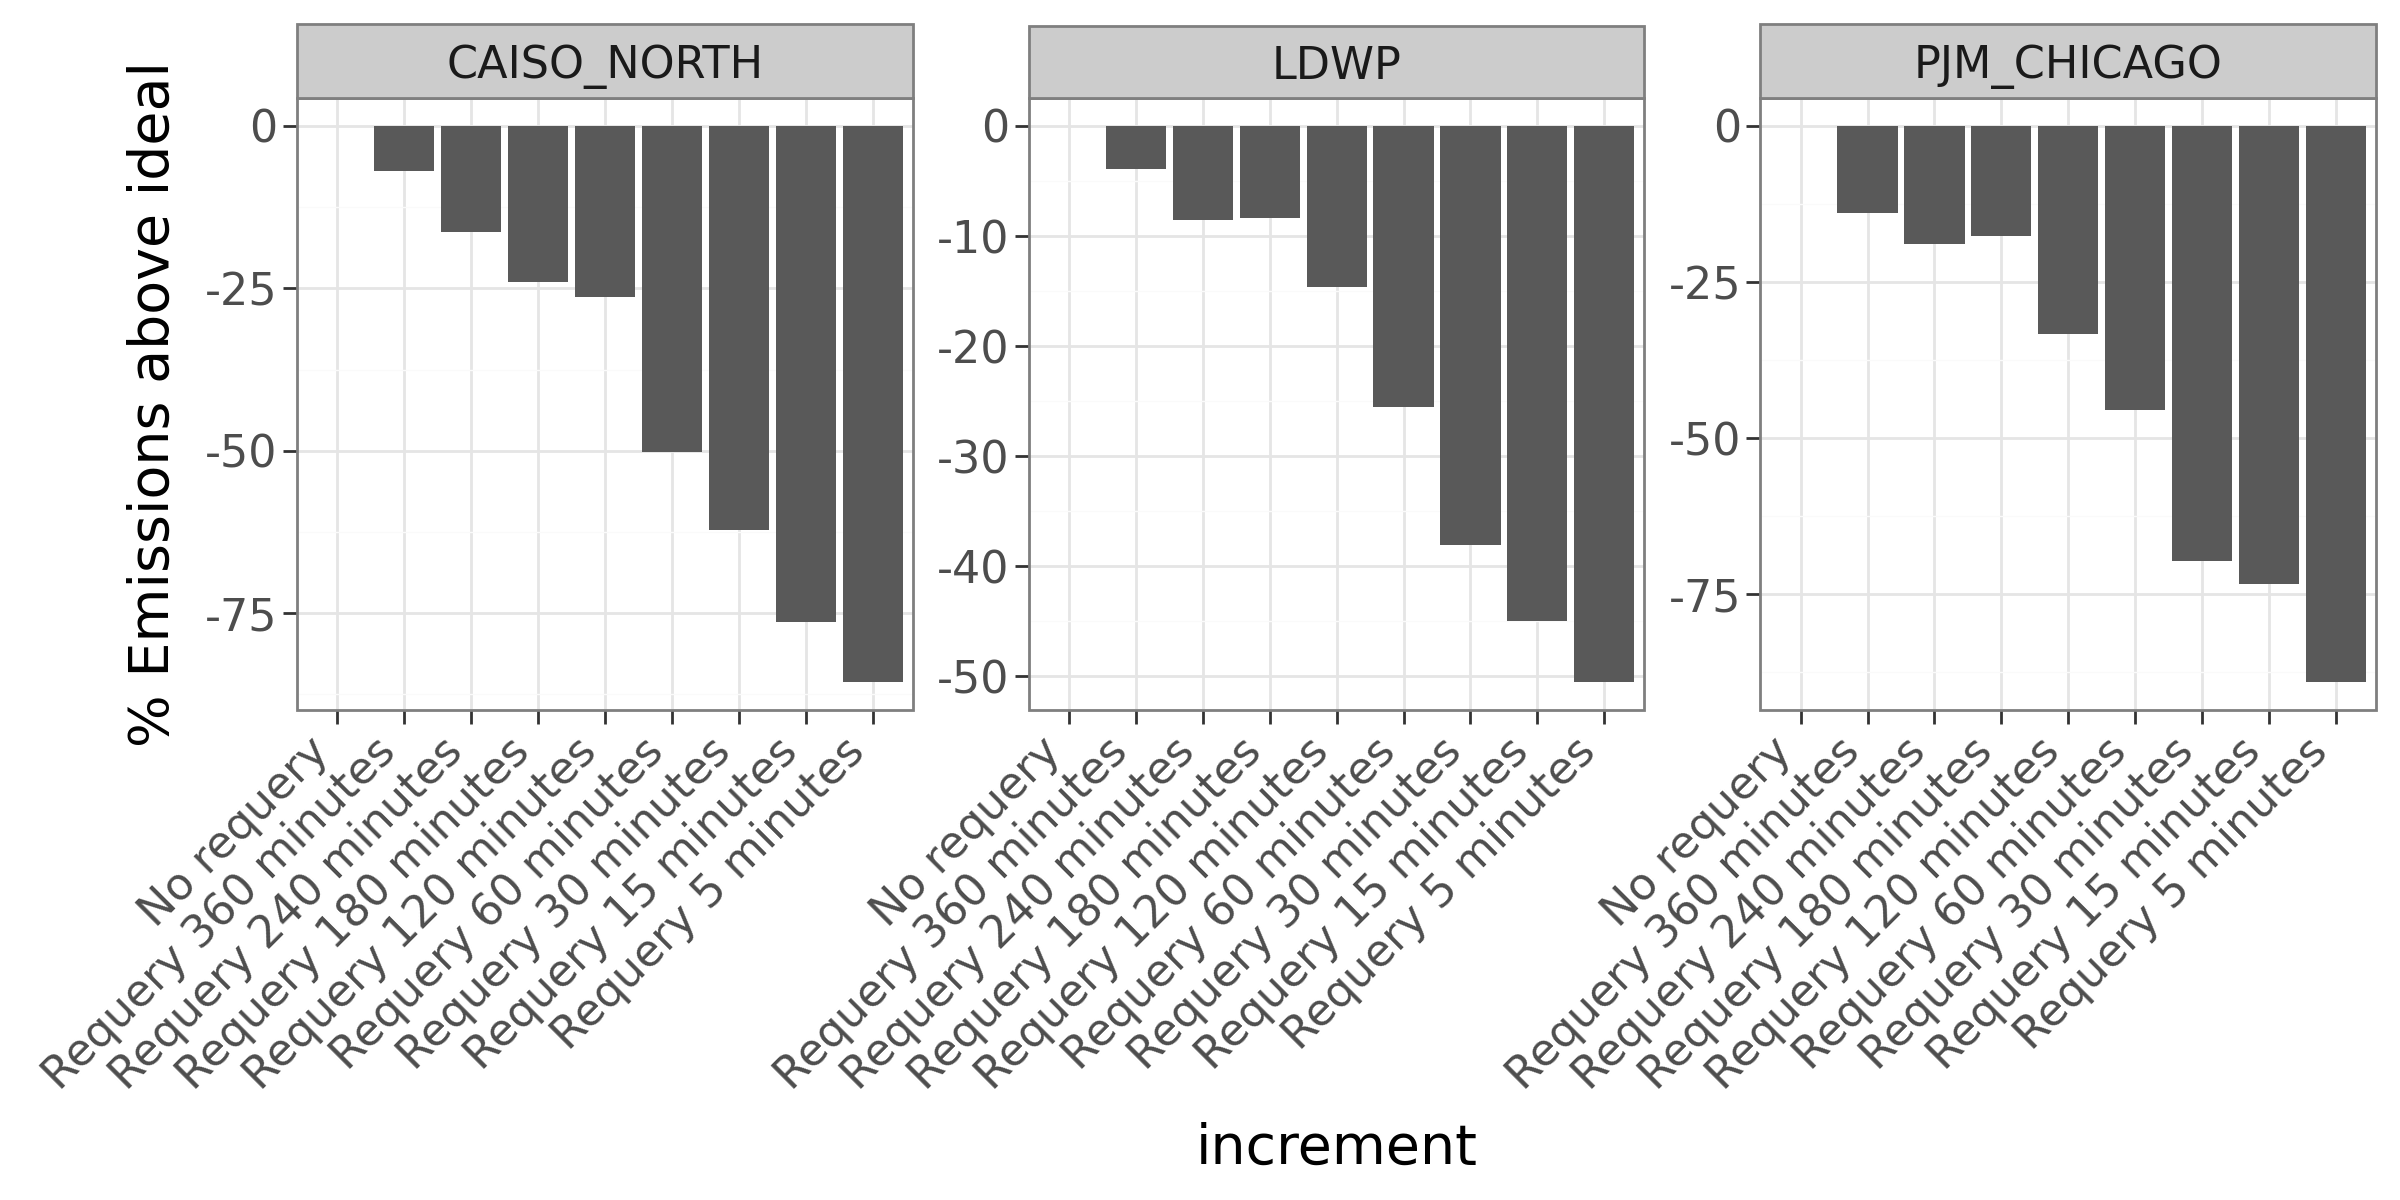

In [11]:
(ggplot(plot_dat.query("region.isin(['PJM_CHICAGO', 'LDWP', 'CAISO_NORTH']) & ~increment.isin(['Baseline', 'Ideal'])"), aes(x = "increment", y = "no_requery_diff")) + geom_bar(stat = "identity") + facet_wrap("~region", scales = "free_y") + theme_bw(base_size=20) +
     theme(figure_size=(12, 6),axis_text_x=element_text(angle=45, hjust=1)) + labs(y = "% Emissions above ideal"))

In [12]:
plot_dat

region            increment  ideal_diff_pct  baseline_diff_pct  \
0   CAISO_NORTH                Ideal        0.000000       18787.331030   
1   CAISO_NORTH             Baseline    95235.065390           0.000000   
2   CAISO_NORTH           No requery    16690.969555       11575.689207   
3   CAISO_NORTH  Requery 360 minutes    16459.838158       11684.729620   
4   CAISO_NORTH  Requery 240 minutes    15619.085900       12076.925338   
..          ...                  ...             ...                ...   
94       SPP_TX  Requery 120 minutes   438944.365743      -79357.220671   
95       SPP_TX   Requery 60 minutes   473165.848699      -91875.064304   
96       SPP_TX   Requery 30 minutes   468696.020304      -91393.559704   
97       SPP_TX   Requery 15 minutes   459409.555709      -89985.163091   
98       SPP_TX    Requery 5 minutes   449195.399164      -88003.134697   

    ideal_diff  baseline_diff  no_requery_diff_pct  no_requery_diff  
0     0.000000     966.316500          8727.132121      -308.147333  
1   966.316500       0.000000        -66620.308879       658.169167  
2   308.147333     658.169167             0.000000         0.000000  
3   301.202167     665.114333            25.471216        -6.945167  
4   291.871833     674.444667           348.469358       -16.275500  
..         ...            ...                  ...              ...  
94  906.723667     962.919500        -87135.548203       -16.292667  
95  888.321167     981.322000       -109773.427177       -34.695167  
96  860.838667    1008.804500       -114281.839912       -62.177667  
97  831.170333    1038.472833       -110773.578708       -91.846000  
98  814.674000    1054.969167       -107971.477939      -108.342333  

[99 rows x 8 columns]

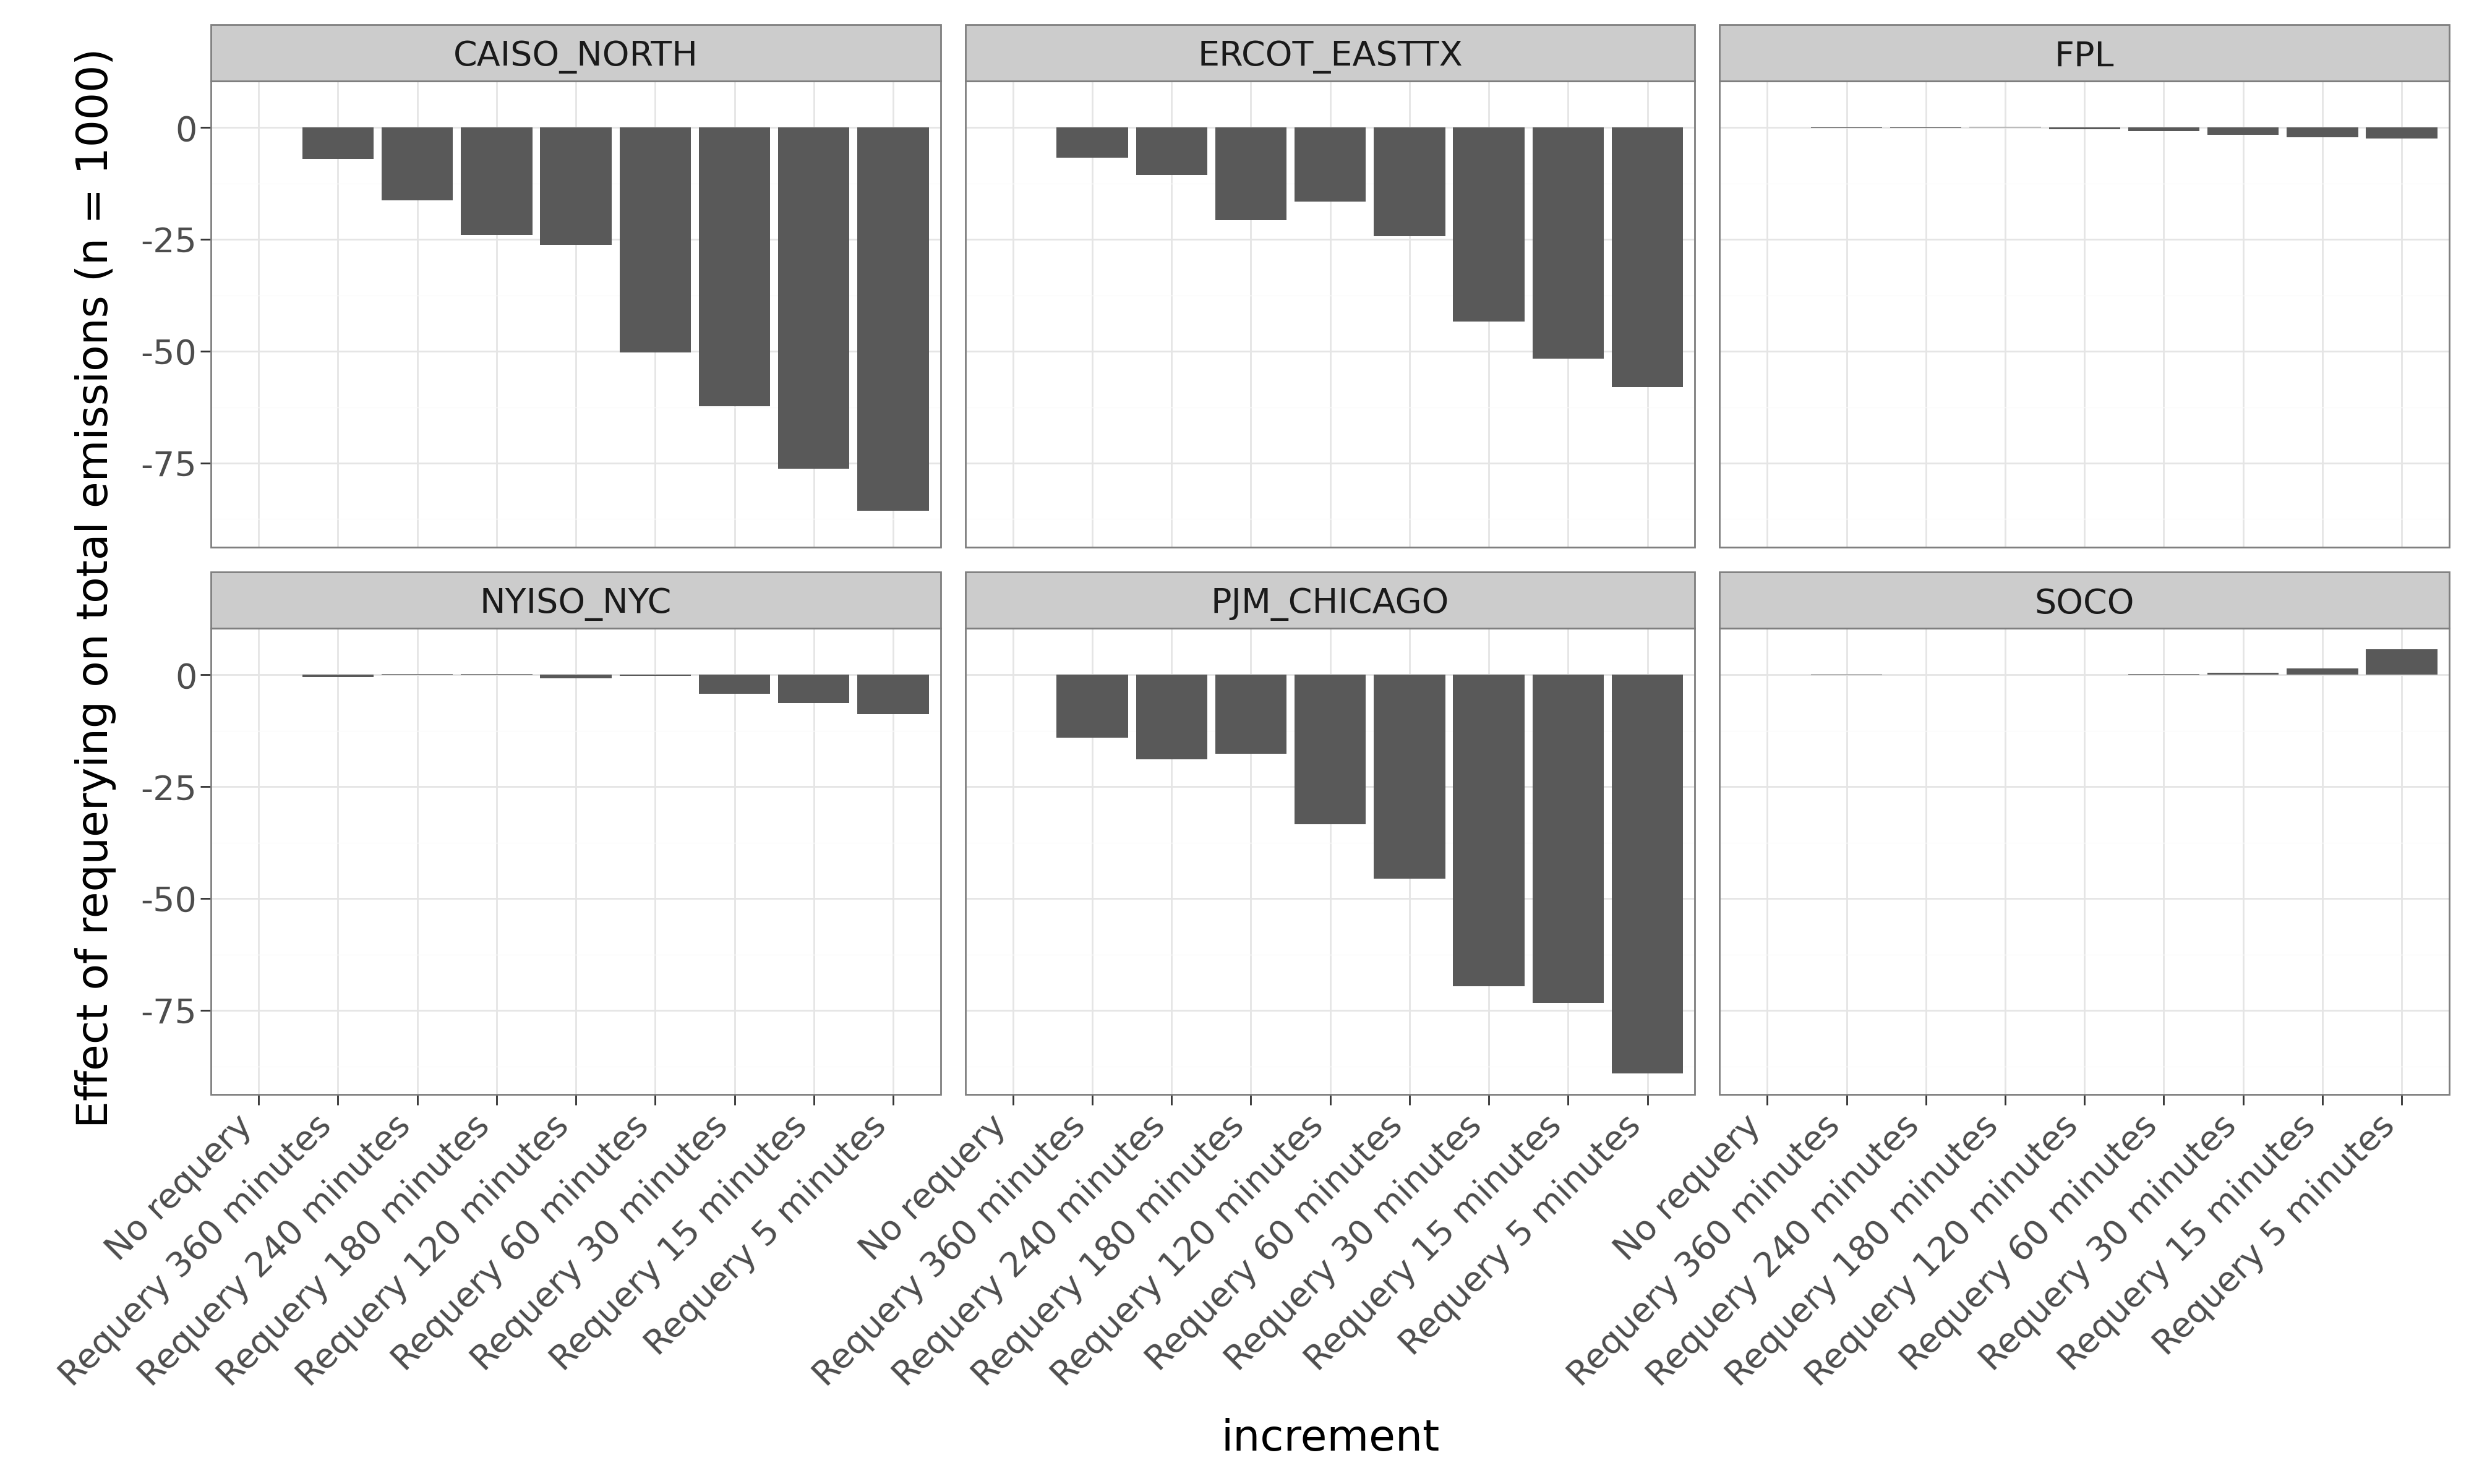

In [13]:
(ggplot(plot_dat.query("~increment.isin(['Baseline', 'Ideal']) & ~region.isin(['SPP_TX', 'LDWP', 'PJM_DC'])"), aes(x = "increment", y = "no_requery_diff")) + geom_bar(stat = "identity") + facet_wrap("~region") + theme_bw(base_size=25) +
     theme(figure_size=(20, 12),axis_text_x=element_text(angle=45, hjust=1)) + labs(y = "Effect of requerying on total emissions (n = 1000)"))

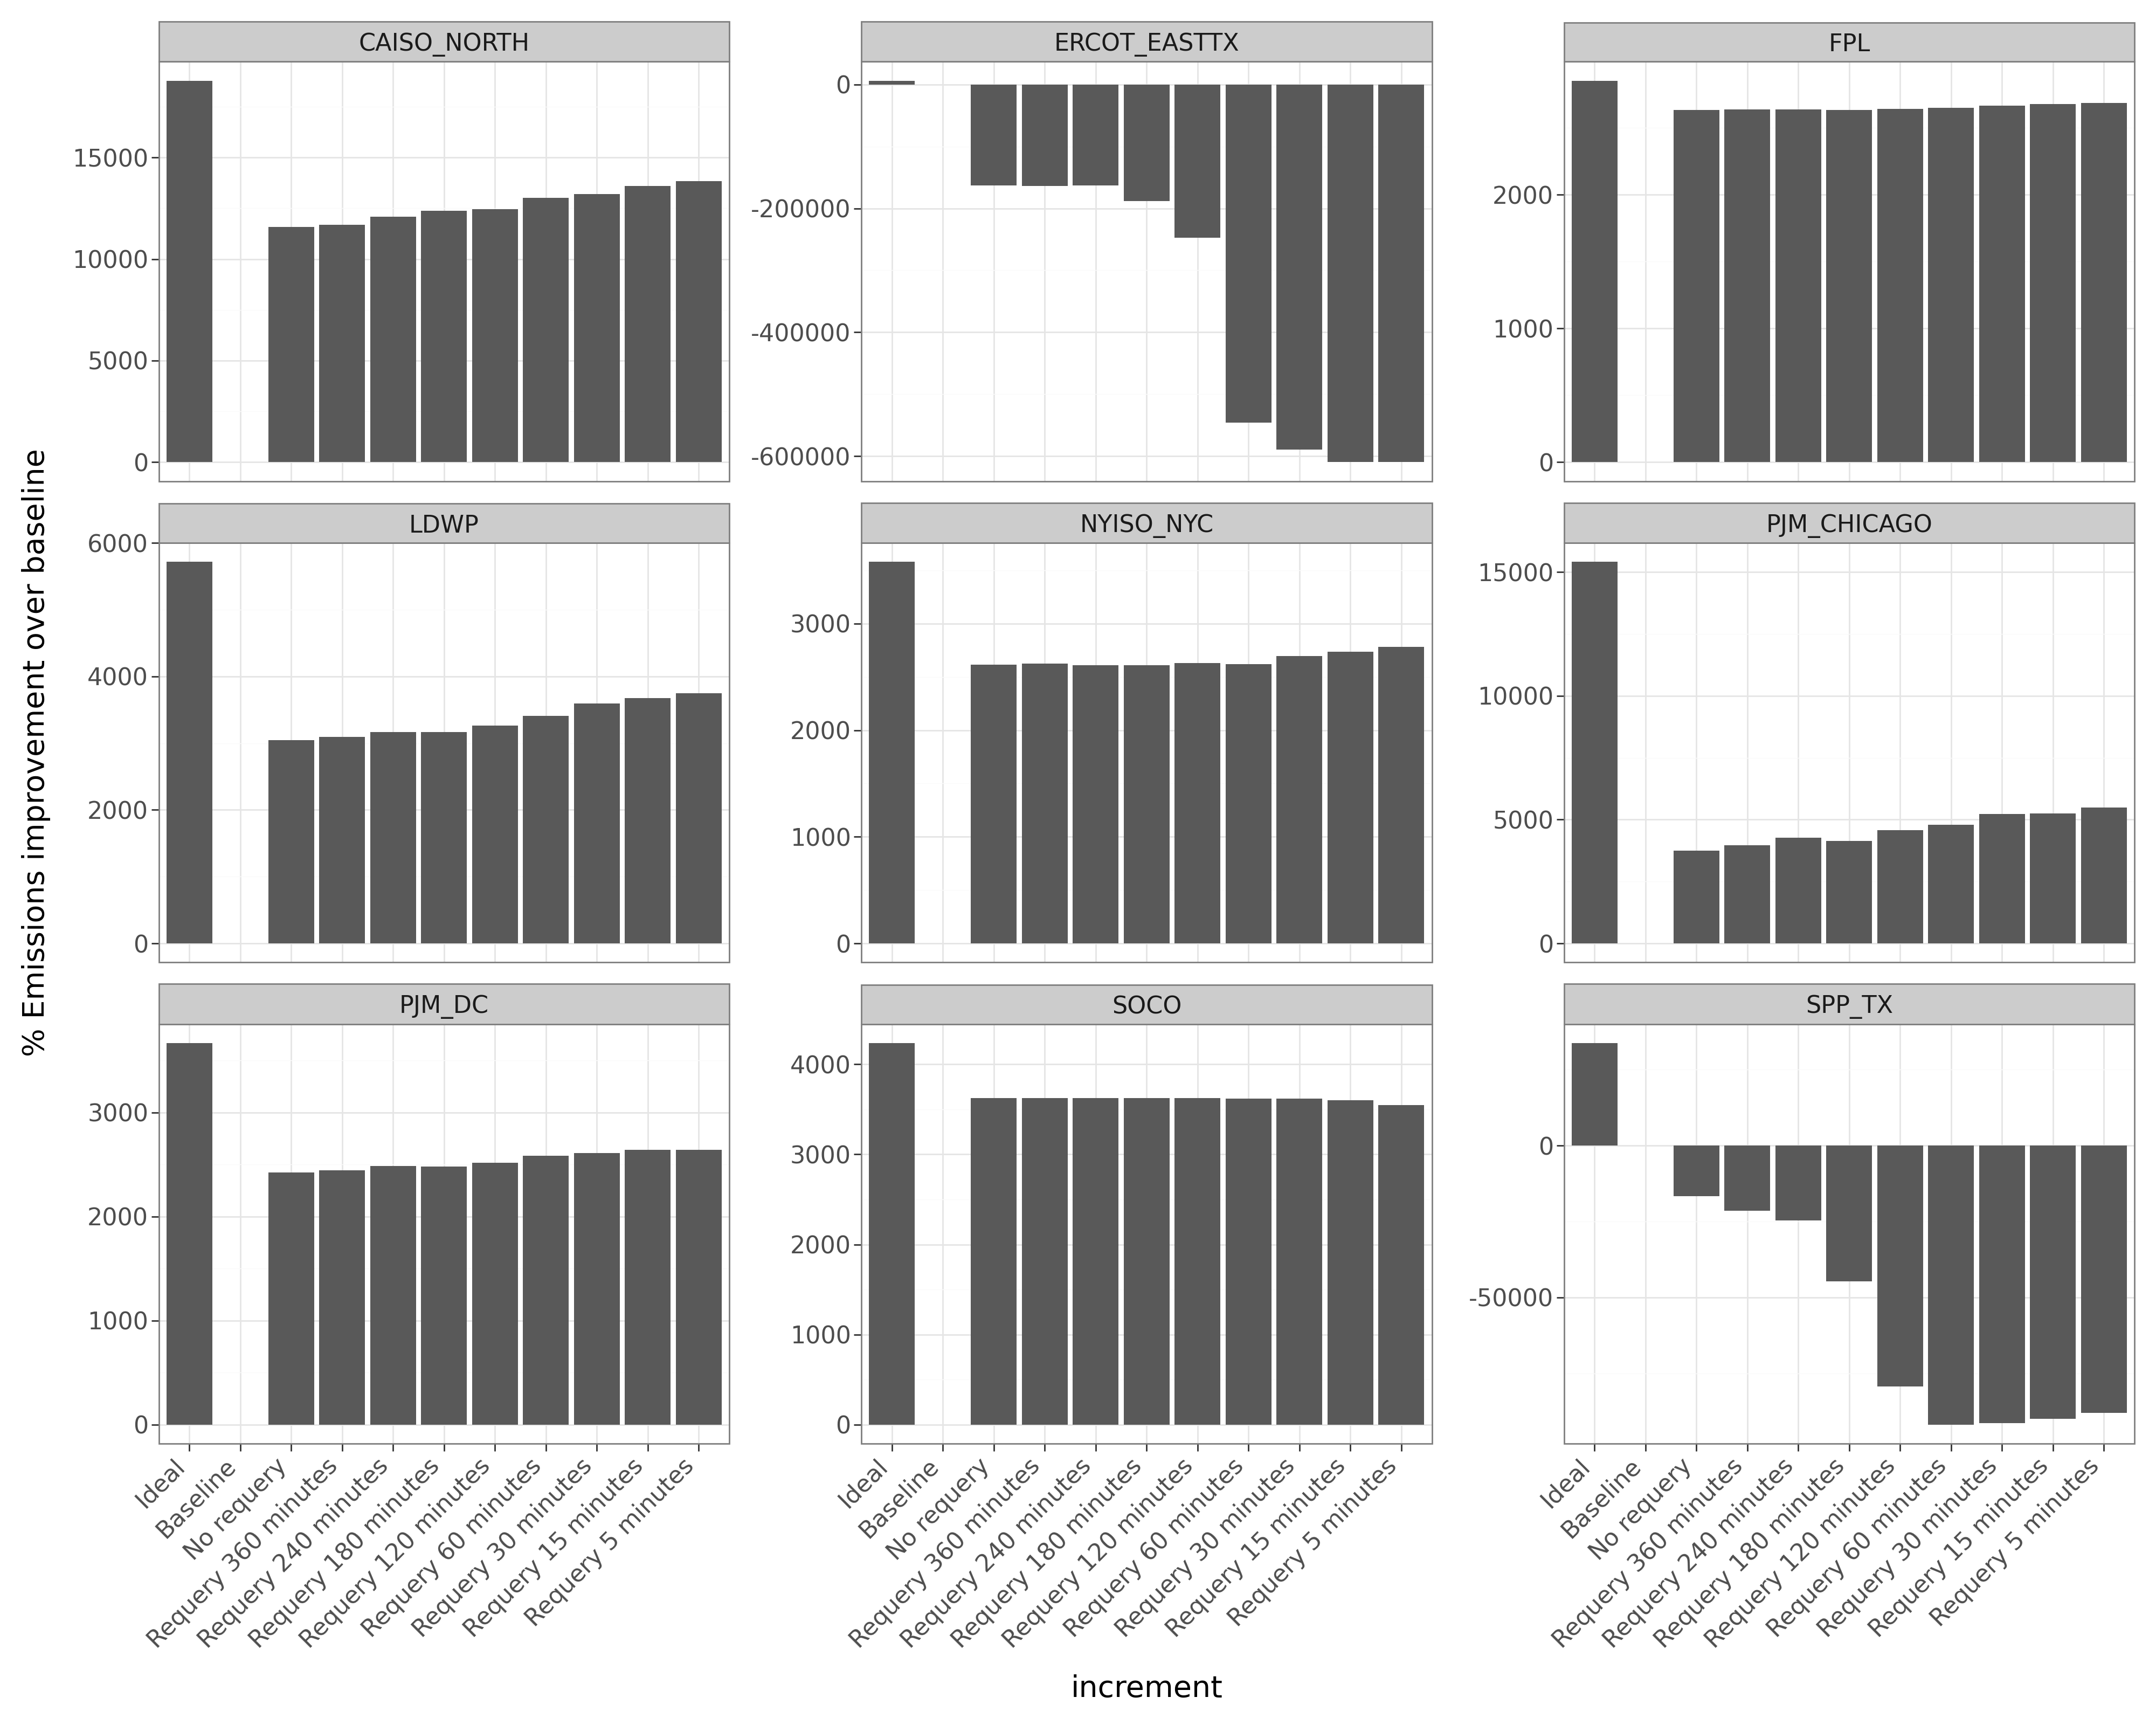

In [14]:
(ggplot(plot_dat, aes(x = "increment", y = "baseline_diff_pct")) + geom_bar(stat = "identity") + facet_wrap("~region", scales = "free_y") + theme_bw(base_size=20) +
     theme(figure_size=(20, 16),axis_text_x=element_text(angle=45, hjust=1)) + labs(y = "% Emissions improvement over baseline"))

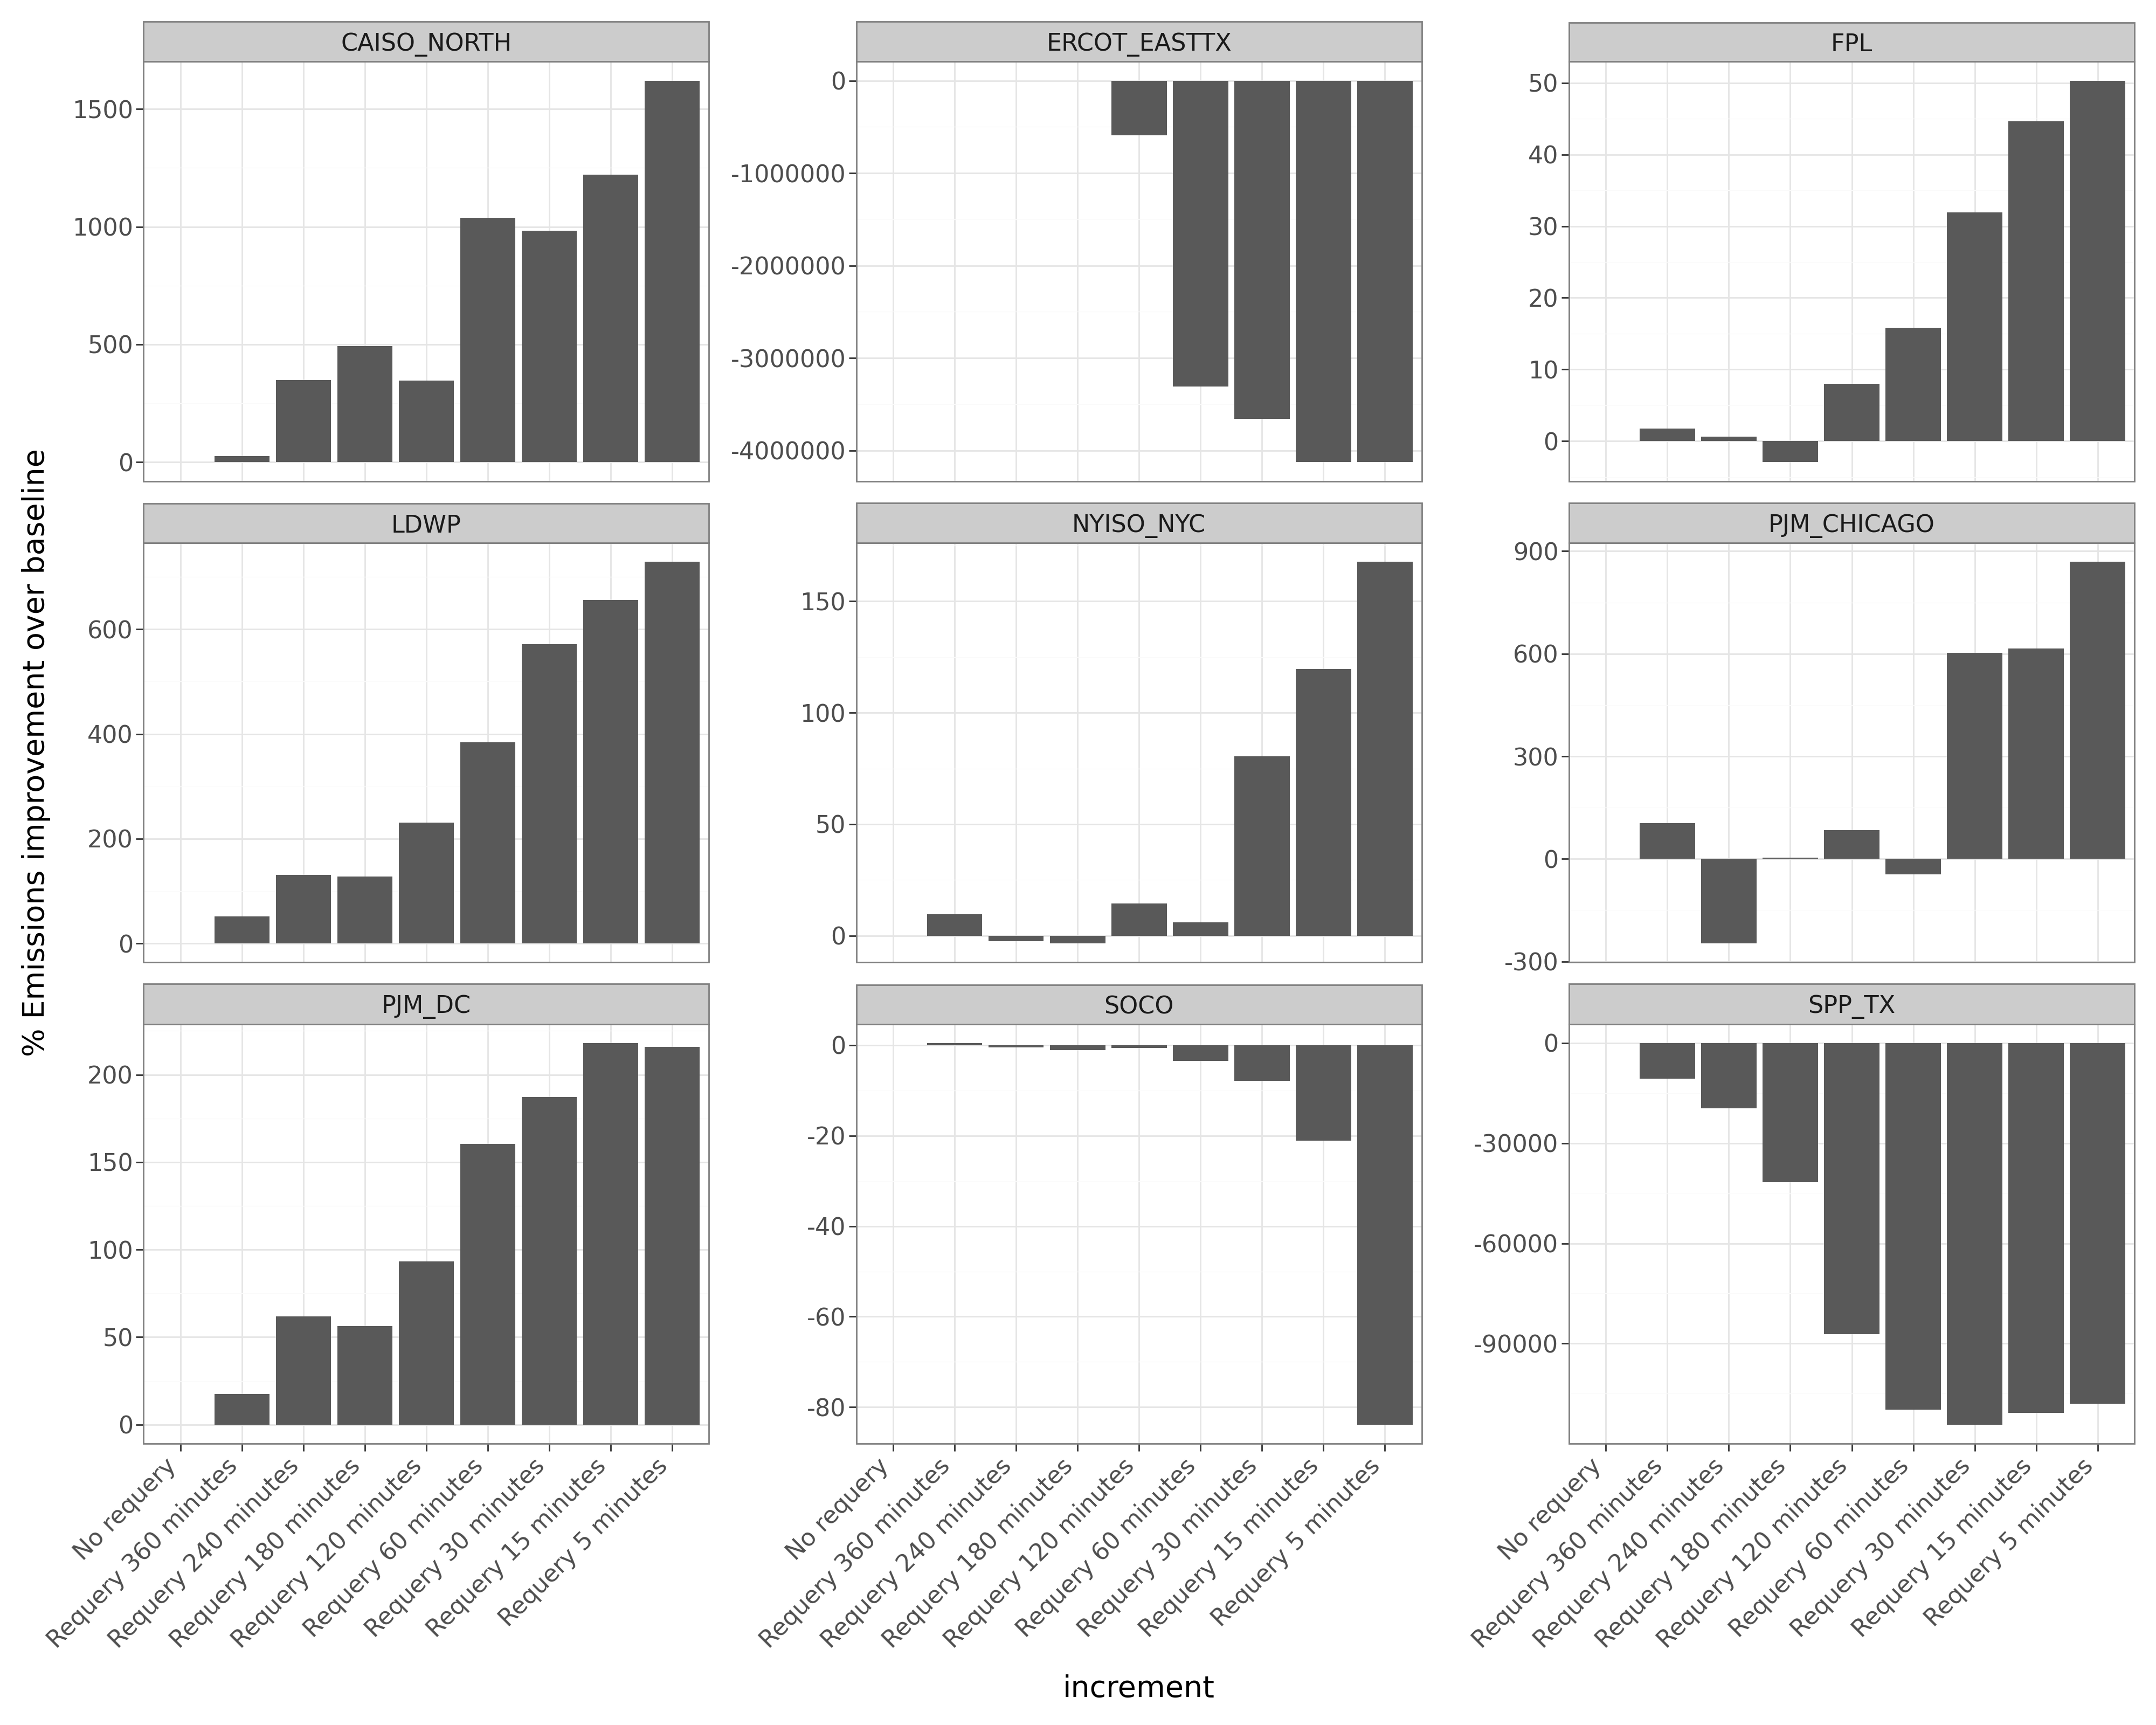

In [15]:
(ggplot(plot_dat.query("~increment.isin(['Ideal', 'Baseline'])"), aes(x = "increment", y = "no_requery_diff_pct")) + geom_bar(stat = "identity") + facet_wrap("~region", scales = "free_y") + theme_bw(base_size=20) +
     theme(figure_size=(20, 16),axis_text_x=element_text(angle=45, hjust=1)) + labs(y = "% Emissions improvement over baseline"))

In [16]:
totals_comp.query("increment == 'Requery 15 minutes'")

increment       region                 init_time  \
80271  Requery 15 minutes  CAISO_NORTH 2023-01-01 02:57:27+00:00   
80272  Requery 15 minutes  CAISO_NORTH 2023-01-01 13:39:42+00:00   
80273  Requery 15 minutes  CAISO_NORTH 2023-01-01 15:46:29+00:00   
80274  Requery 15 minutes  CAISO_NORTH 2023-01-02 01:51:58+00:00   
80275  Requery 15 minutes  CAISO_NORTH 2023-01-02 03:16:43+00:00   
...                   ...          ...                       ...   
89185  Requery 15 minutes       SPP_TX 2023-12-29 01:54:28+00:00   
89186  Requery 15 minutes       SPP_TX 2023-12-29 14:16:03+00:00   
89187  Requery 15 minutes       SPP_TX 2023-12-29 18:48:25+00:00   
89188  Requery 15 minutes       SPP_TX 2023-12-29 20:50:42+00:00   
89189  Requery 15 minutes       SPP_TX 2023-12-30 02:34:58+00:00   

       actual_emissions  emissions_co2e_lb  ideal_emissions  \
80271          5.722833           5.723450         5.706667   
80272          6.010667           5.963483         5.913667   
80273          5.983833           5.950100         5.952167   
80274          5.491333           5.531483         5.459833   
80275          5.500000           5.537150         5.459667   
...                 ...                ...              ...   
89185          1.059667           0.471983         0.069167   
89186          3.638833           2.863617         3.306333   
89187          8.654000           8.437800         8.326167   
89188          8.721833           8.424017         8.326167   
89189          8.467333           8.226567         8.387333   

       baseline_emissions  no_requery_emissions  ideal_diff_pct  \
80271            5.821667              5.740500        0.283294   
80272            6.295667              6.013333        1.640268   
80273            6.435333              6.013333        0.532019   
80274            5.953833              5.830833        0.576941   
80275            5.890667              5.830833        0.738751   
...                   ...                   ...             ...   
89185            8.347833              0.083667     1432.048193   
89186            3.544833              3.590333       10.056457   
89187            8.683667              8.675833        3.937386   
89188            8.467500              8.771000        4.752087   
89189            8.660833              8.586333        0.953819   

       baseline_diff_pct  ideal_diff  baseline_diff  no_requery_diff_pct  \
80271           1.697681    0.016167       0.098833             0.307755   
80272           4.526923    0.097000       0.285000             0.044346   
80273           7.015954    0.031667       0.451500             0.490576   
80274           7.768105    0.031500       0.462500             5.822495   
80275           6.631960    0.040333       0.390667             5.673860   
...                  ...         ...            ...                  ...   
89185          87.306087    0.990500       7.288167         -1166.533865   
89186          -2.651747    0.332500      -0.094000            -1.350850   
89187           0.341638    0.327833       0.029667             0.251657   
89188          -3.003641    0.395667      -0.254333             0.560559   
89189           2.234196    0.080000       0.193500             1.385923   

       no_requery_diff  
80271        -0.017667  
80272        -0.002667  
80273        -0.029500  
80274        -0.339500  
80275        -0.330833  
...                ...  
89185         0.976000  
89186         0.048500  
89187        -0.021833  
89188        -0.049167  
89189        -0.119000  

[8919 rows x 14 columns]

In [19]:
full_schedules = requery_results.set_index("init_time").loc['2023-01-01 02:57:27+00:00'].reset_index().query("region == 'CAISO_NORTH' & increment.isin(['Ideal', 'No requery', 'Requery 120 minutes', 'Requery 5 minutes'])")

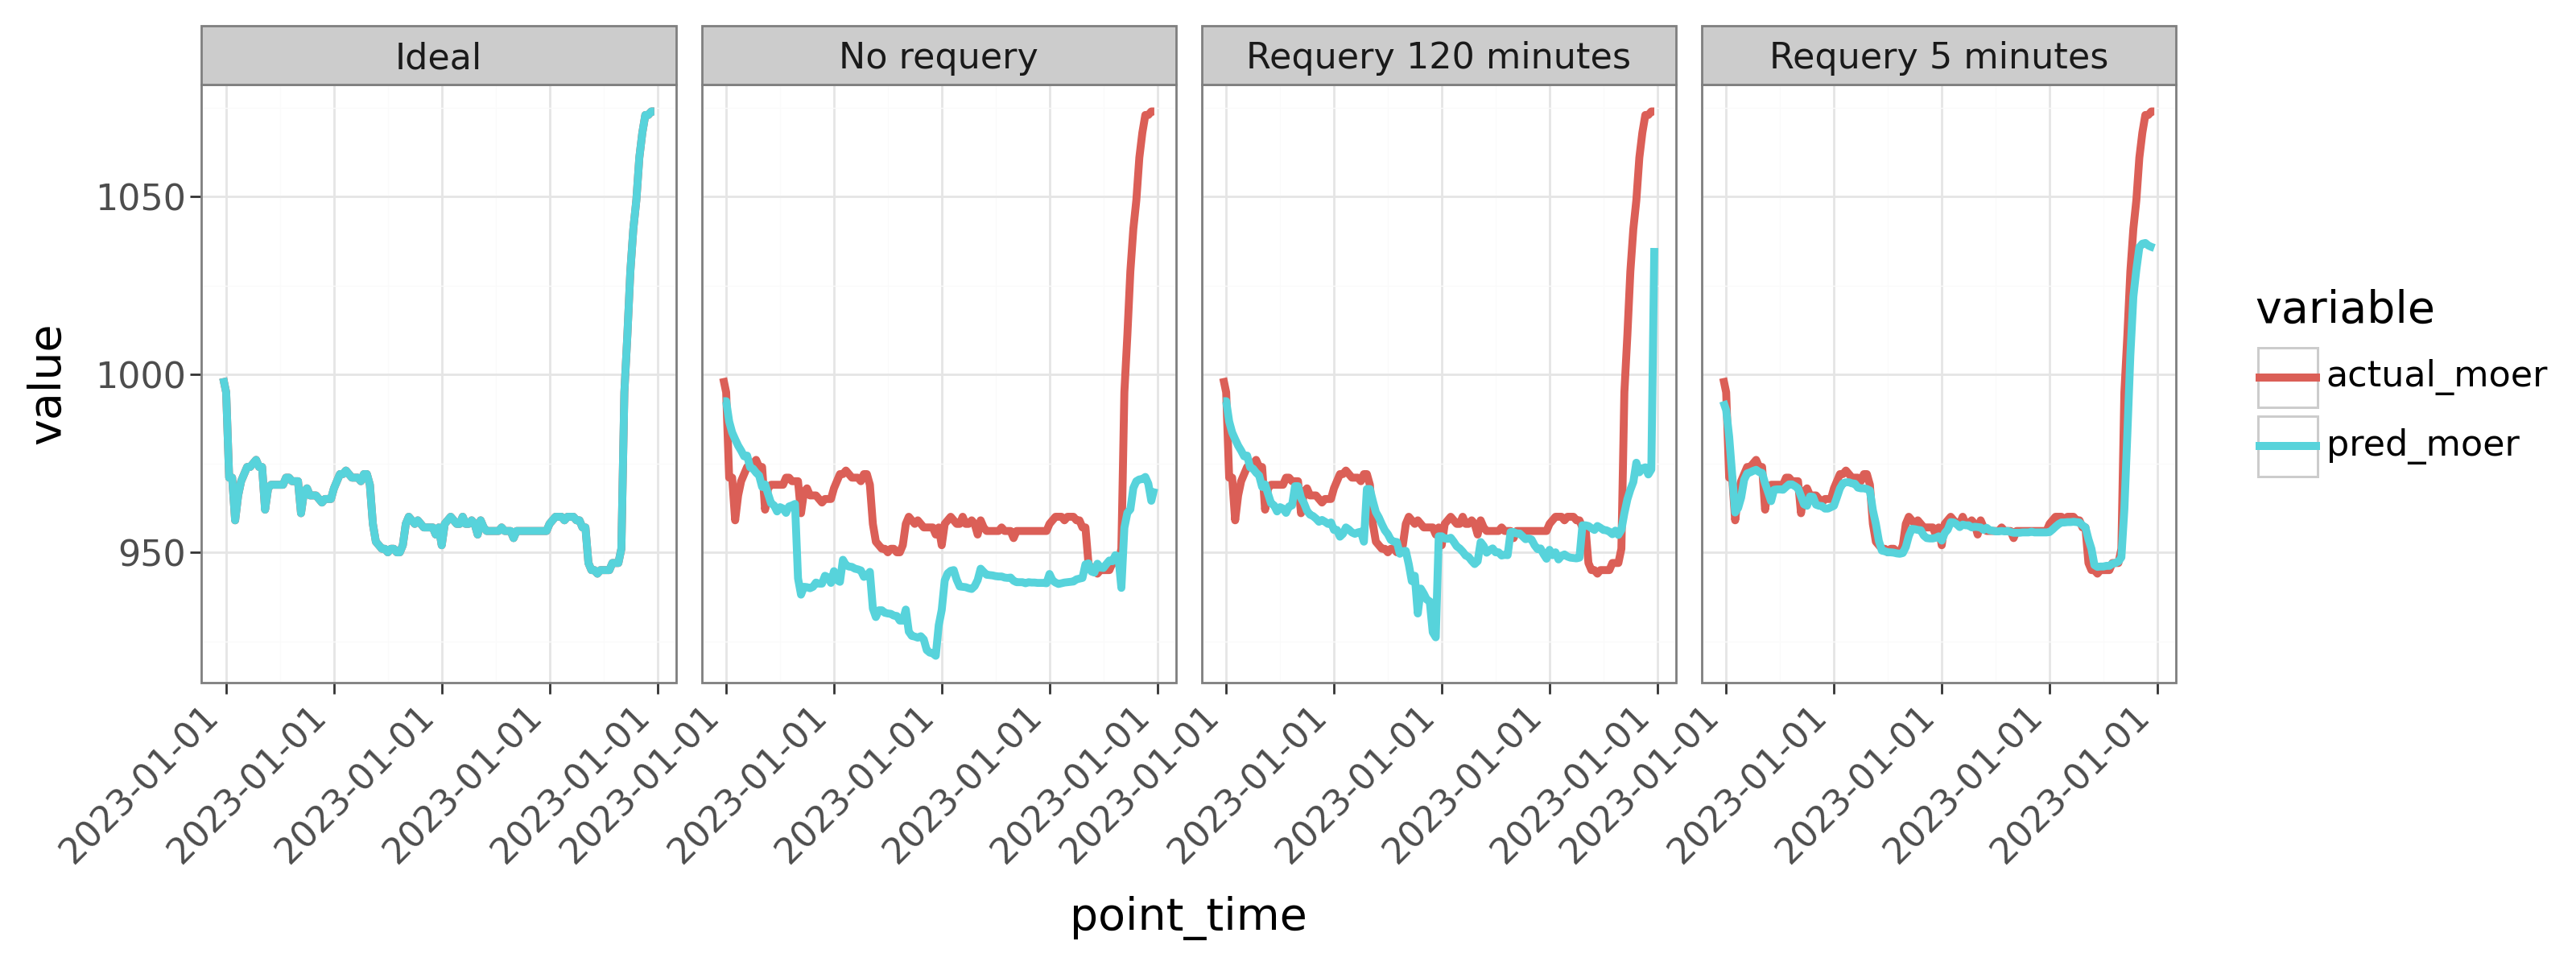

In [20]:
plot_dat = full_schedules.melt(id_vars = ["point_time", "increment"], value_vars=["actual_moer", "pred_moer"])
p = (ggplot(plot_dat, aes(x="point_time", y="value", color = "variable")) +
     geom_line(size=2) +
     facet_wrap("~increment", nrow = 1) +
     theme_bw(base_size=20) +
     theme(figure_size=(16, 6),
           axis_text_x=element_text(angle=45, hjust=1))  # Rotate x-axis labels
    )

p

/tmp/ipykernel_420099/3385855388.py:10: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


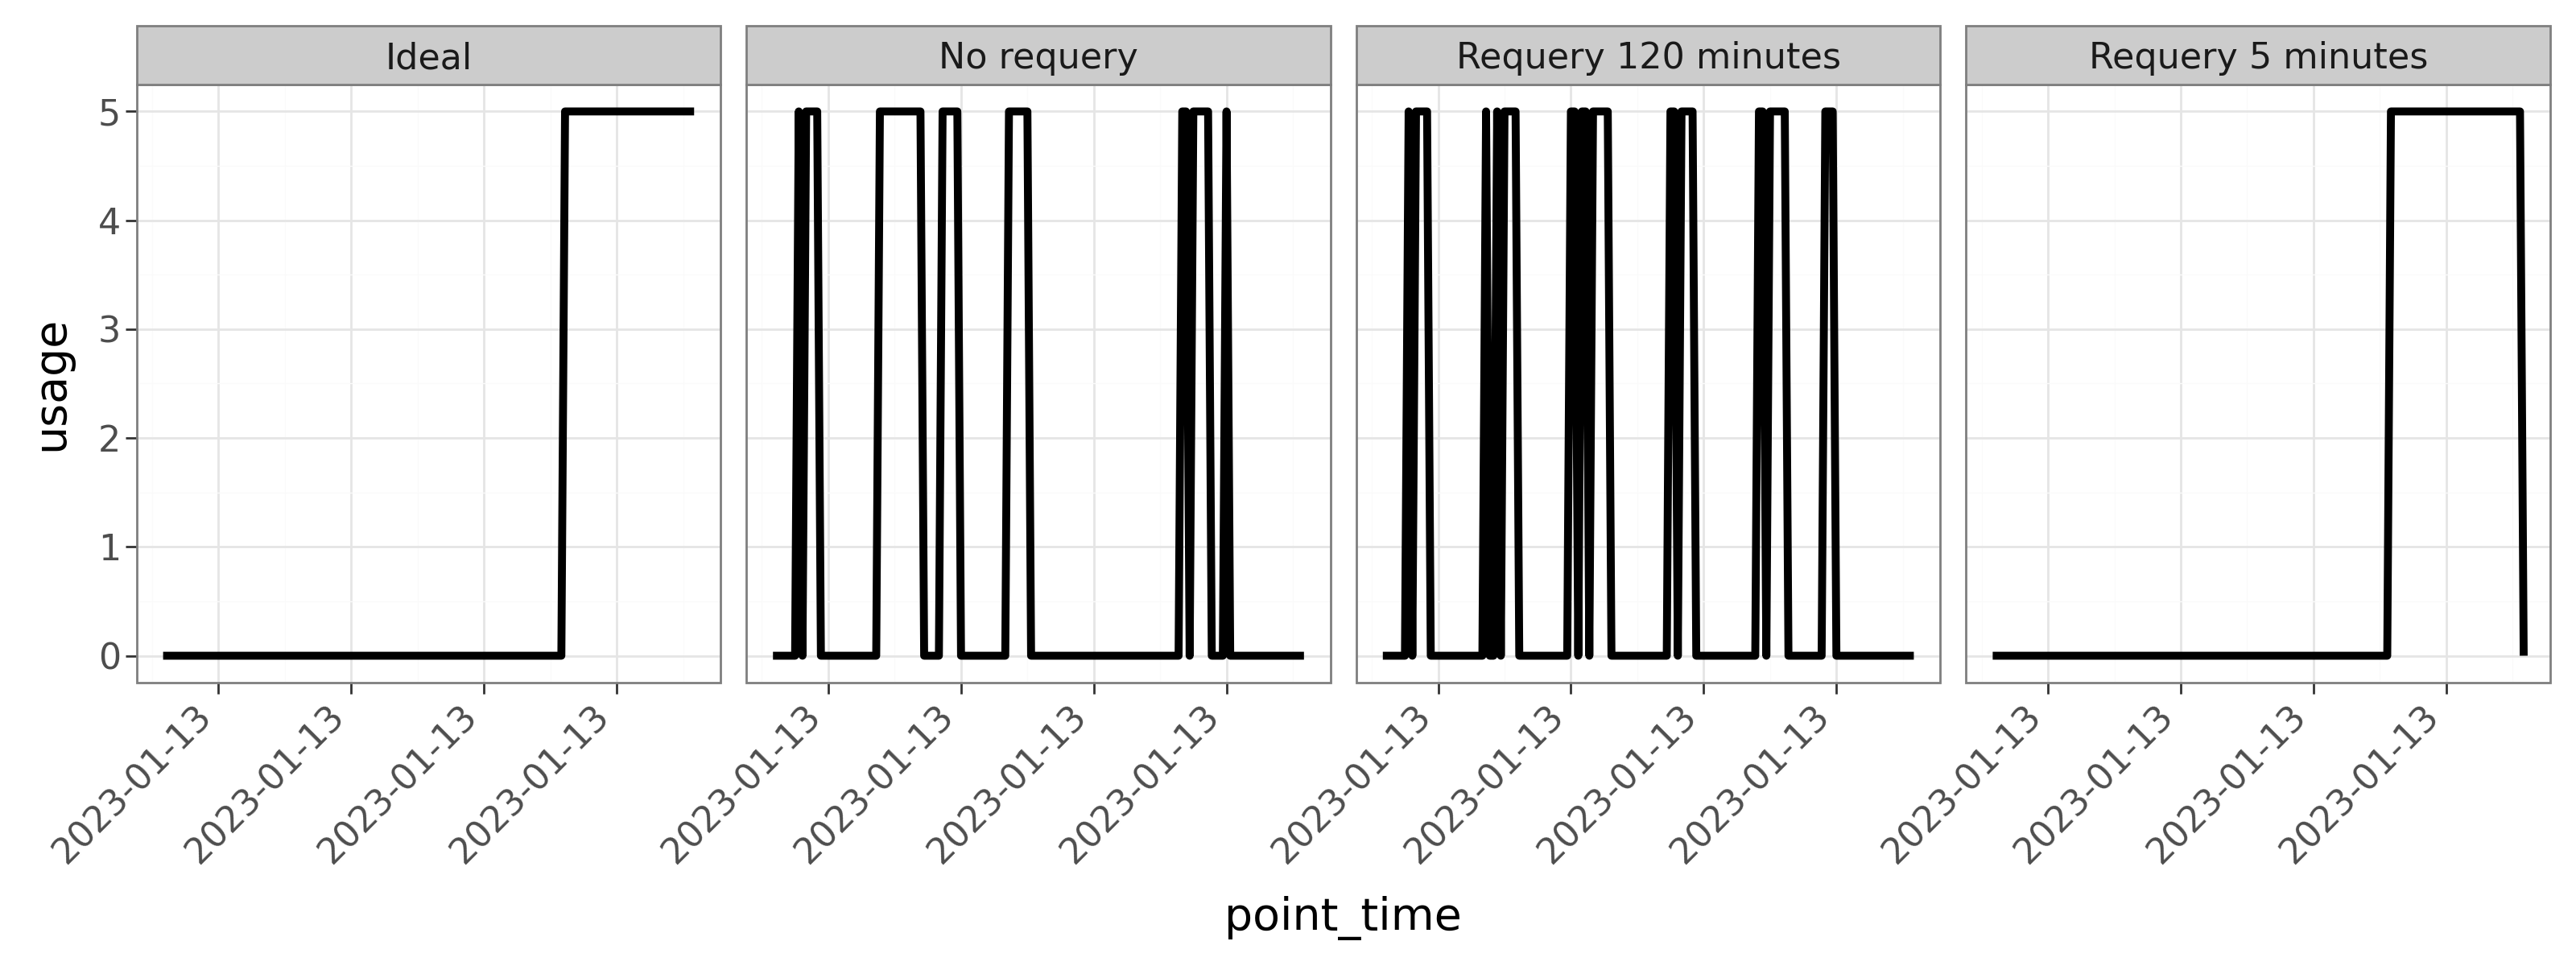

In [ ]:
p = (ggplot(full_schedules, aes(x="point_time", y="usage")) +
     geom_line(size=2) +
     facet_wrap("~increment", nrow = 1) +
     theme_bw(base_size=20) +
     theme(figure_size=(16, 6),
           axis_text_x=element_text(angle=45, hjust=1))  # Rotate x-axis labels
    )


print(p)

In [ ]:
totals_comp.query("increment == 'Requery 5 minutes' & no_requery_diff_pct < -10").sample(10)

increment        region                 init_time  \
14712  Requery 5 minutes        SPP_TX 2023-01-22 00:28:19+00:00   
13668  Requery 5 minutes  ERCOT_EASTTX 2023-02-10 13:58:31+00:00   
14733  Requery 5 minutes        SPP_TX 2023-03-26 00:57:38+00:00   
14818  Requery 5 minutes        SPP_TX 2023-10-01 18:48:58+00:00   
13674  Requery 5 minutes  ERCOT_EASTTX 2023-02-22 02:37:07+00:00   
14833  Requery 5 minutes        SPP_TX 2023-10-29 01:10:38+00:00   
14830  Requery 5 minutes        SPP_TX 2023-10-26 15:42:04+00:00   
14388  Requery 5 minutes   PJM_CHICAGO 2023-11-14 22:26:21+00:00   
13532  Requery 5 minutes   CAISO_NORTH 2023-03-25 09:34:18+00:00   
14397  Requery 5 minutes   PJM_CHICAGO 2023-12-25 00:38:13+00:00   

       actual_emissions  emissions_co2e_lb  ideal_emissions  \
14712          8.606667           8.466600         2.247333   
13668          6.298667           7.063983         0.006000   
14733          1.438000           2.603383         0.414500   
14818          1.235167           0.855700         0.071667   
13674          6.838667           7.010667         2.725667   
14833          4.941500           3.453700         2.603167   
14830          0.599333           0.923283         0.075167   
14388          5.656667           5.259150         0.553667   
13532          0.720500           0.713950         0.545500   
14397          1.453500           3.368117         0.259333   

       baseline_emissions  no_requery_emissions  ideal_diff_pct  \
14712            8.524500              6.036500      282.972412   
13668            7.142667              3.375000   104877.777778   
14733            2.531167              0.788167      246.924005   
14818            1.018667              0.079167     1623.488372   
13674            7.146333              5.389667      150.898863   
14833            8.762167              3.873500       89.826493   
14830            6.538000              0.083000      697.339246   
14388            6.315167              5.037000      921.673691   
13532            5.661167              0.553000       32.080660   
14397            1.453500              1.278667      460.475578   

       baseline_diff_pct  ideal_diff  baseline_diff  no_requery_diff_pct  \
14712          -0.963888    6.359333      -0.082167           -42.577100   
13668          11.816315    6.292667       0.844000           -86.627160   
14733          43.188253    1.023500       1.093167           -82.448721   
14818         -21.253272    1.163500      -0.216500         -1460.210526   
13674           4.305238    4.113000       0.307667           -26.884780   
14833          43.604131    2.338333       3.820667           -27.571963   
14830          90.833078    0.524167       5.938667          -622.088353   
14388          10.427278    5.103000       0.658500           -12.302296   
13532          87.272941    0.175000       4.940667           -30.289331   
14397          -0.000000    1.194167      -0.000000           -13.673097   

       no_requery_diff  
14712         2.570167  
13668         2.923667  
14733         0.649833  
14818         1.156000  
13674         1.449000  
14833         1.068000  
14830         0.516333  
14388         0.619667  
13532         0.167500  
14397         0.174833

In [ ]:
full_schedules = requery_results.set_index("init_time").loc['2023-02-22 02:37:07+00:00'].reset_index().query("region == 'ERCOT_EASTTX' & increment.isin(['Ideal', 'No requery', 'Requery 120 minutes', 'Requery 5 minutes'])")

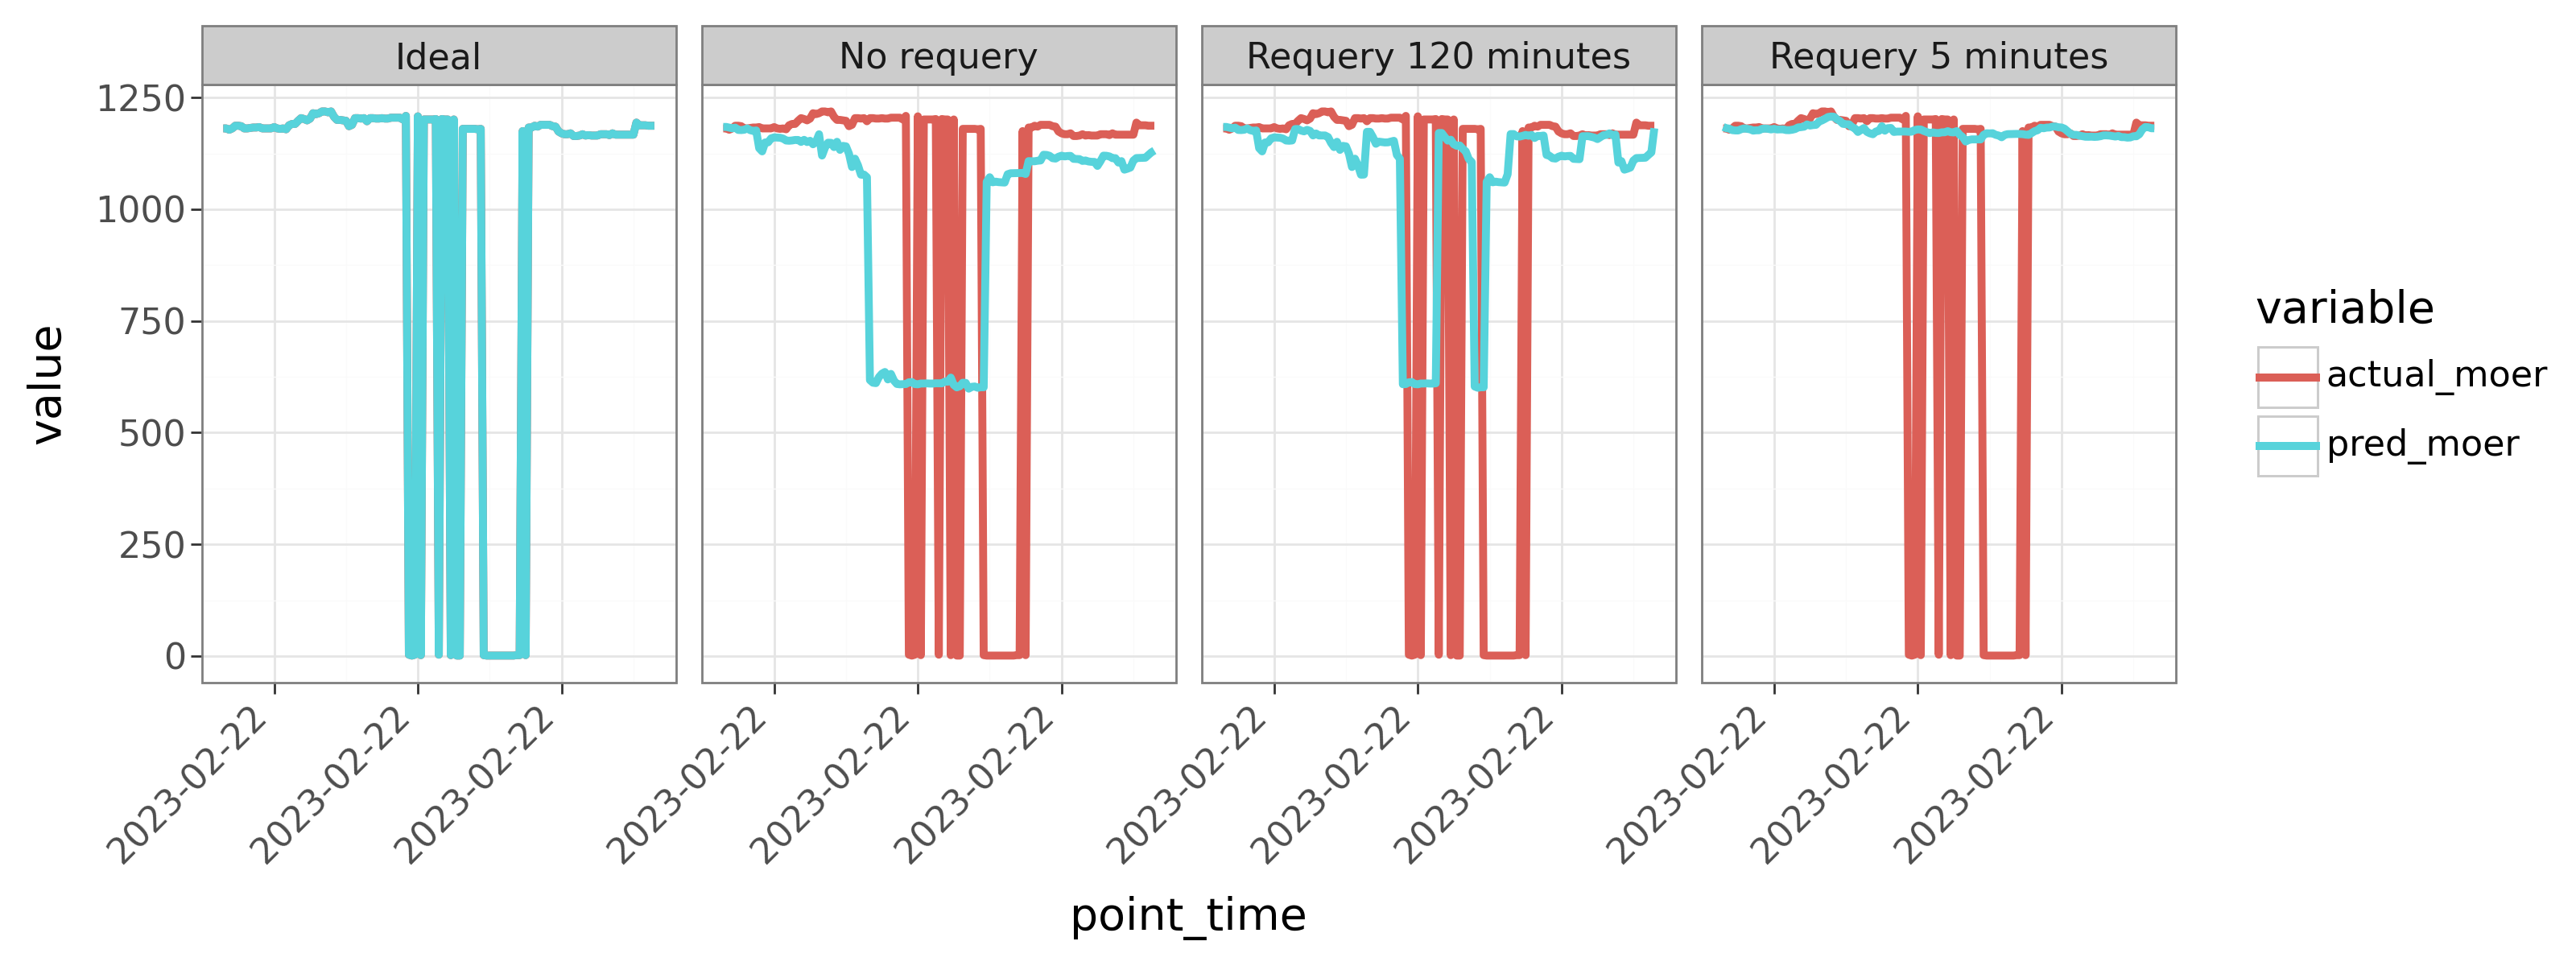

In [ ]:
plot_dat = full_schedules.melt(id_vars = ["point_time", "increment"], value_vars=["actual_moer", "pred_moer"])
p = (ggplot(plot_dat, aes(x="point_time", y="value", color = "variable")) +
     geom_line(size=2) +
     facet_wrap("~increment", nrow = 1) +
     theme_bw(base_size=20) +
     theme(figure_size=(16, 6),
           axis_text_x=element_text(angle=45, hjust=1))  # Rotate x-axis labels
    )

p

/tmp/ipykernel_420099/3385855388.py:10: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


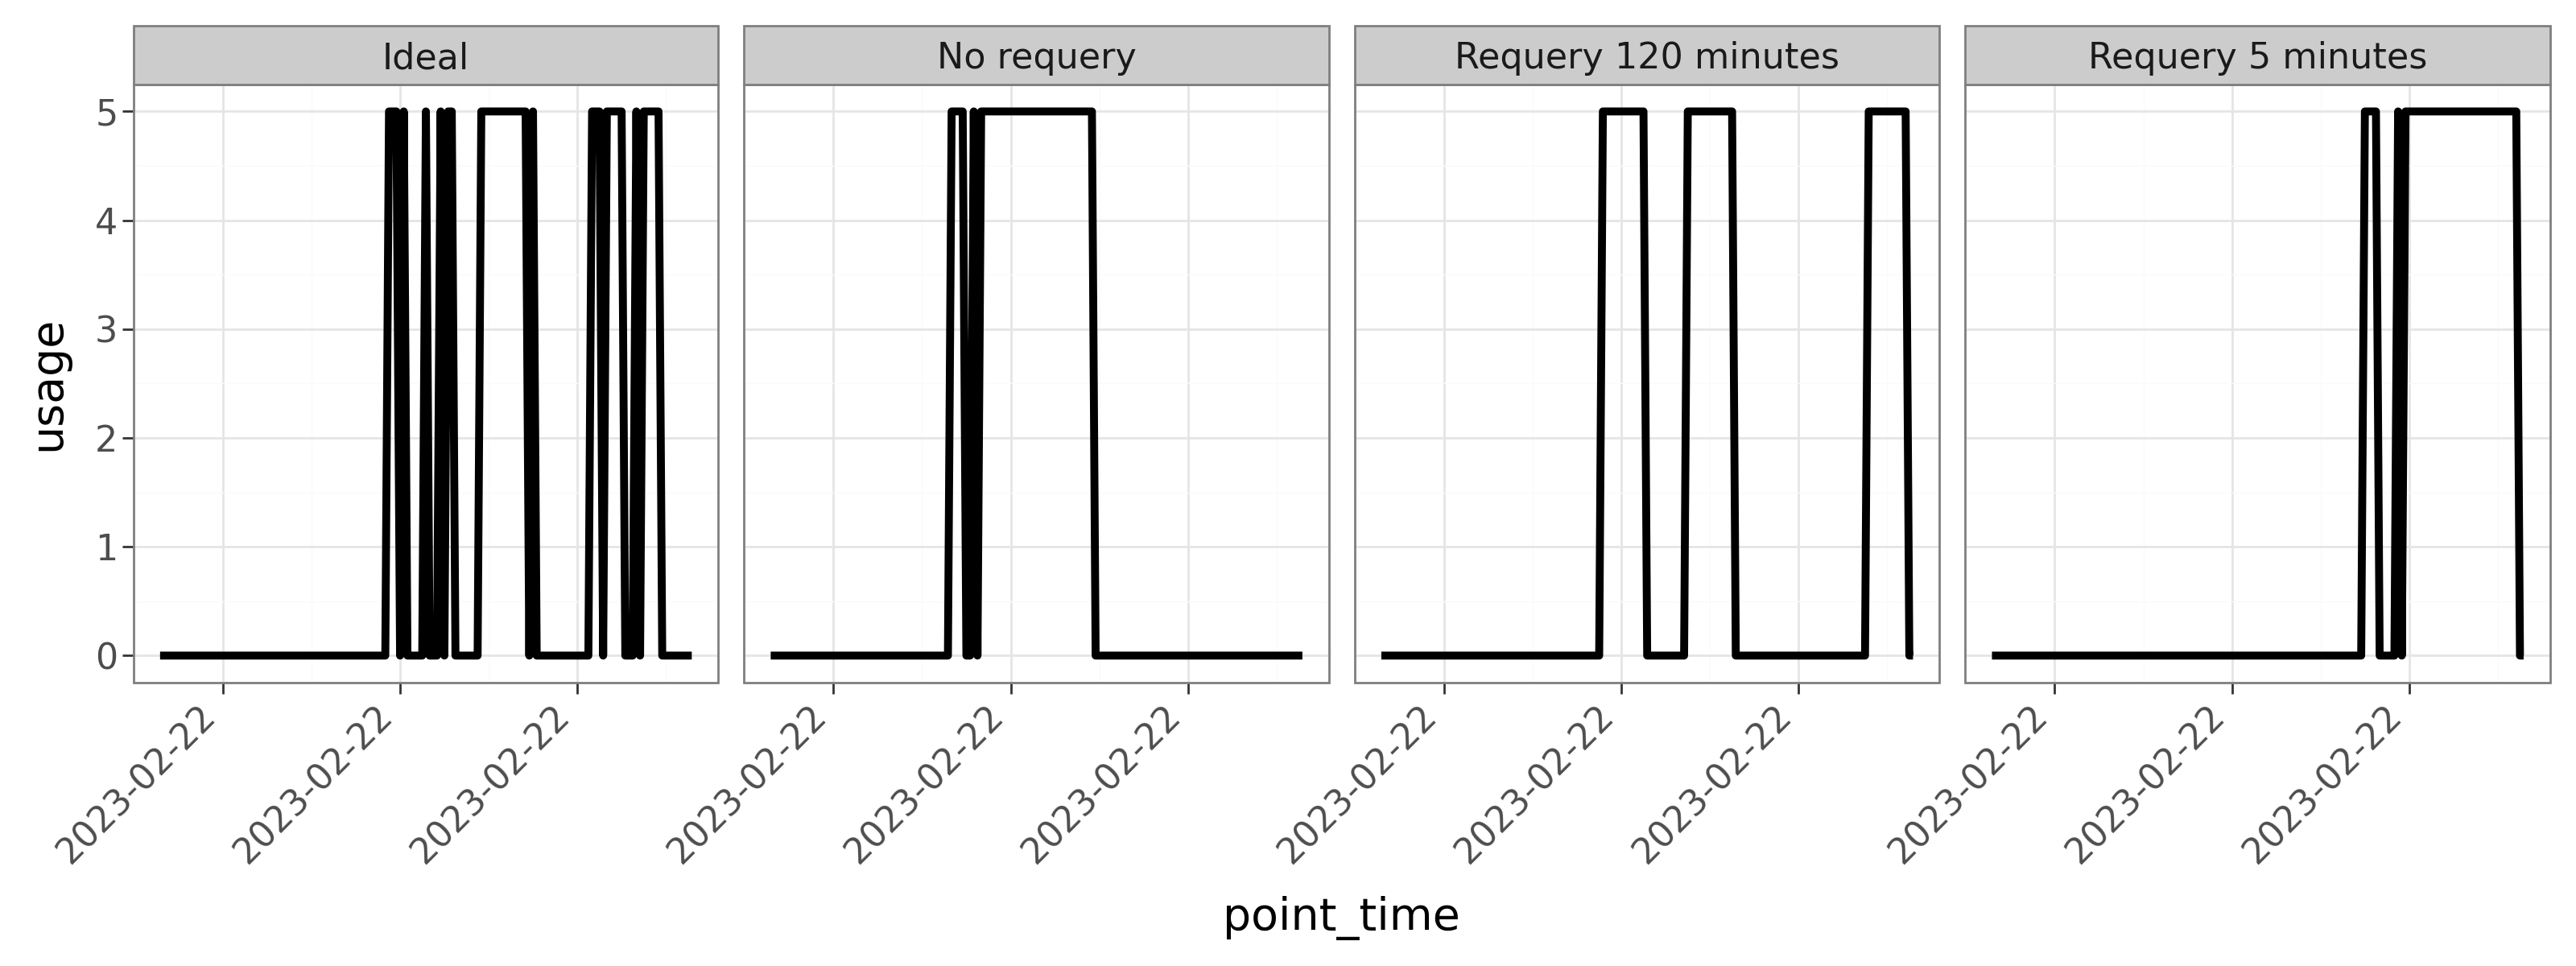

In [ ]:
p = (ggplot(full_schedules, aes(x="point_time", y="usage")) +
     geom_line(size=2) +
     facet_wrap("~increment", nrow = 1) +
     theme_bw(base_size=20) +
     theme(figure_size=(16, 6),
           axis_text_x=element_text(angle=45, hjust=1))  # Rotate x-axis labels
    )


print(p)

In [ ]:
requery_reg_data = requery_results.query("increment == 'No requery'")[["point_time", "region", "init_time", "pred_moer"]]

In [ ]:
requery_reg_data["timestamp"] = pd.to_datetime(requery_reg_data["point_time"]).astype(int) // 10**9

In [ ]:
import statsmodels.api as sm

# Define a function to run regression
def run_regression(group):
    X = group[['timestamp']]  # Independent variables
    X = sm.add_constant(X)    # Adds a constant term to the predictor
    y = group['pred_moer']            # Dependent variable
    model = sm.OLS(y, X).fit()
    return model.params

# Run regression within groups
results = requery_reg_data.groupby(["init_time", "region"]).apply(run_regression).reset_index().drop("const", axis = 1)

/tmp/ipykernel_768156/676906380.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [ ]:
totals_reg = results.merge(totals_comp)
totals_reg["slope_sign"] = np.sign(totals_reg["timestamp"])

In [ ]:
plot_dat = totals_reg.groupby(["region", "slope_sign", "increment"])["no_requery_diff"].mean().reset_index()

/tmp/ipykernel_768156/1267809494.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


In [ ]:
plot_dat = plot_dat.query("increment != 'Ideal' & increment != 'Baseline' & region.isin(['CAISO_NORTH', 'ERCOT_EASTTX', 'NYISO_NYC', 'SOCO'])")

In [ ]:
plot_dat.quer

AttributeError: 'DataFrame' object has no attribute 'quer'

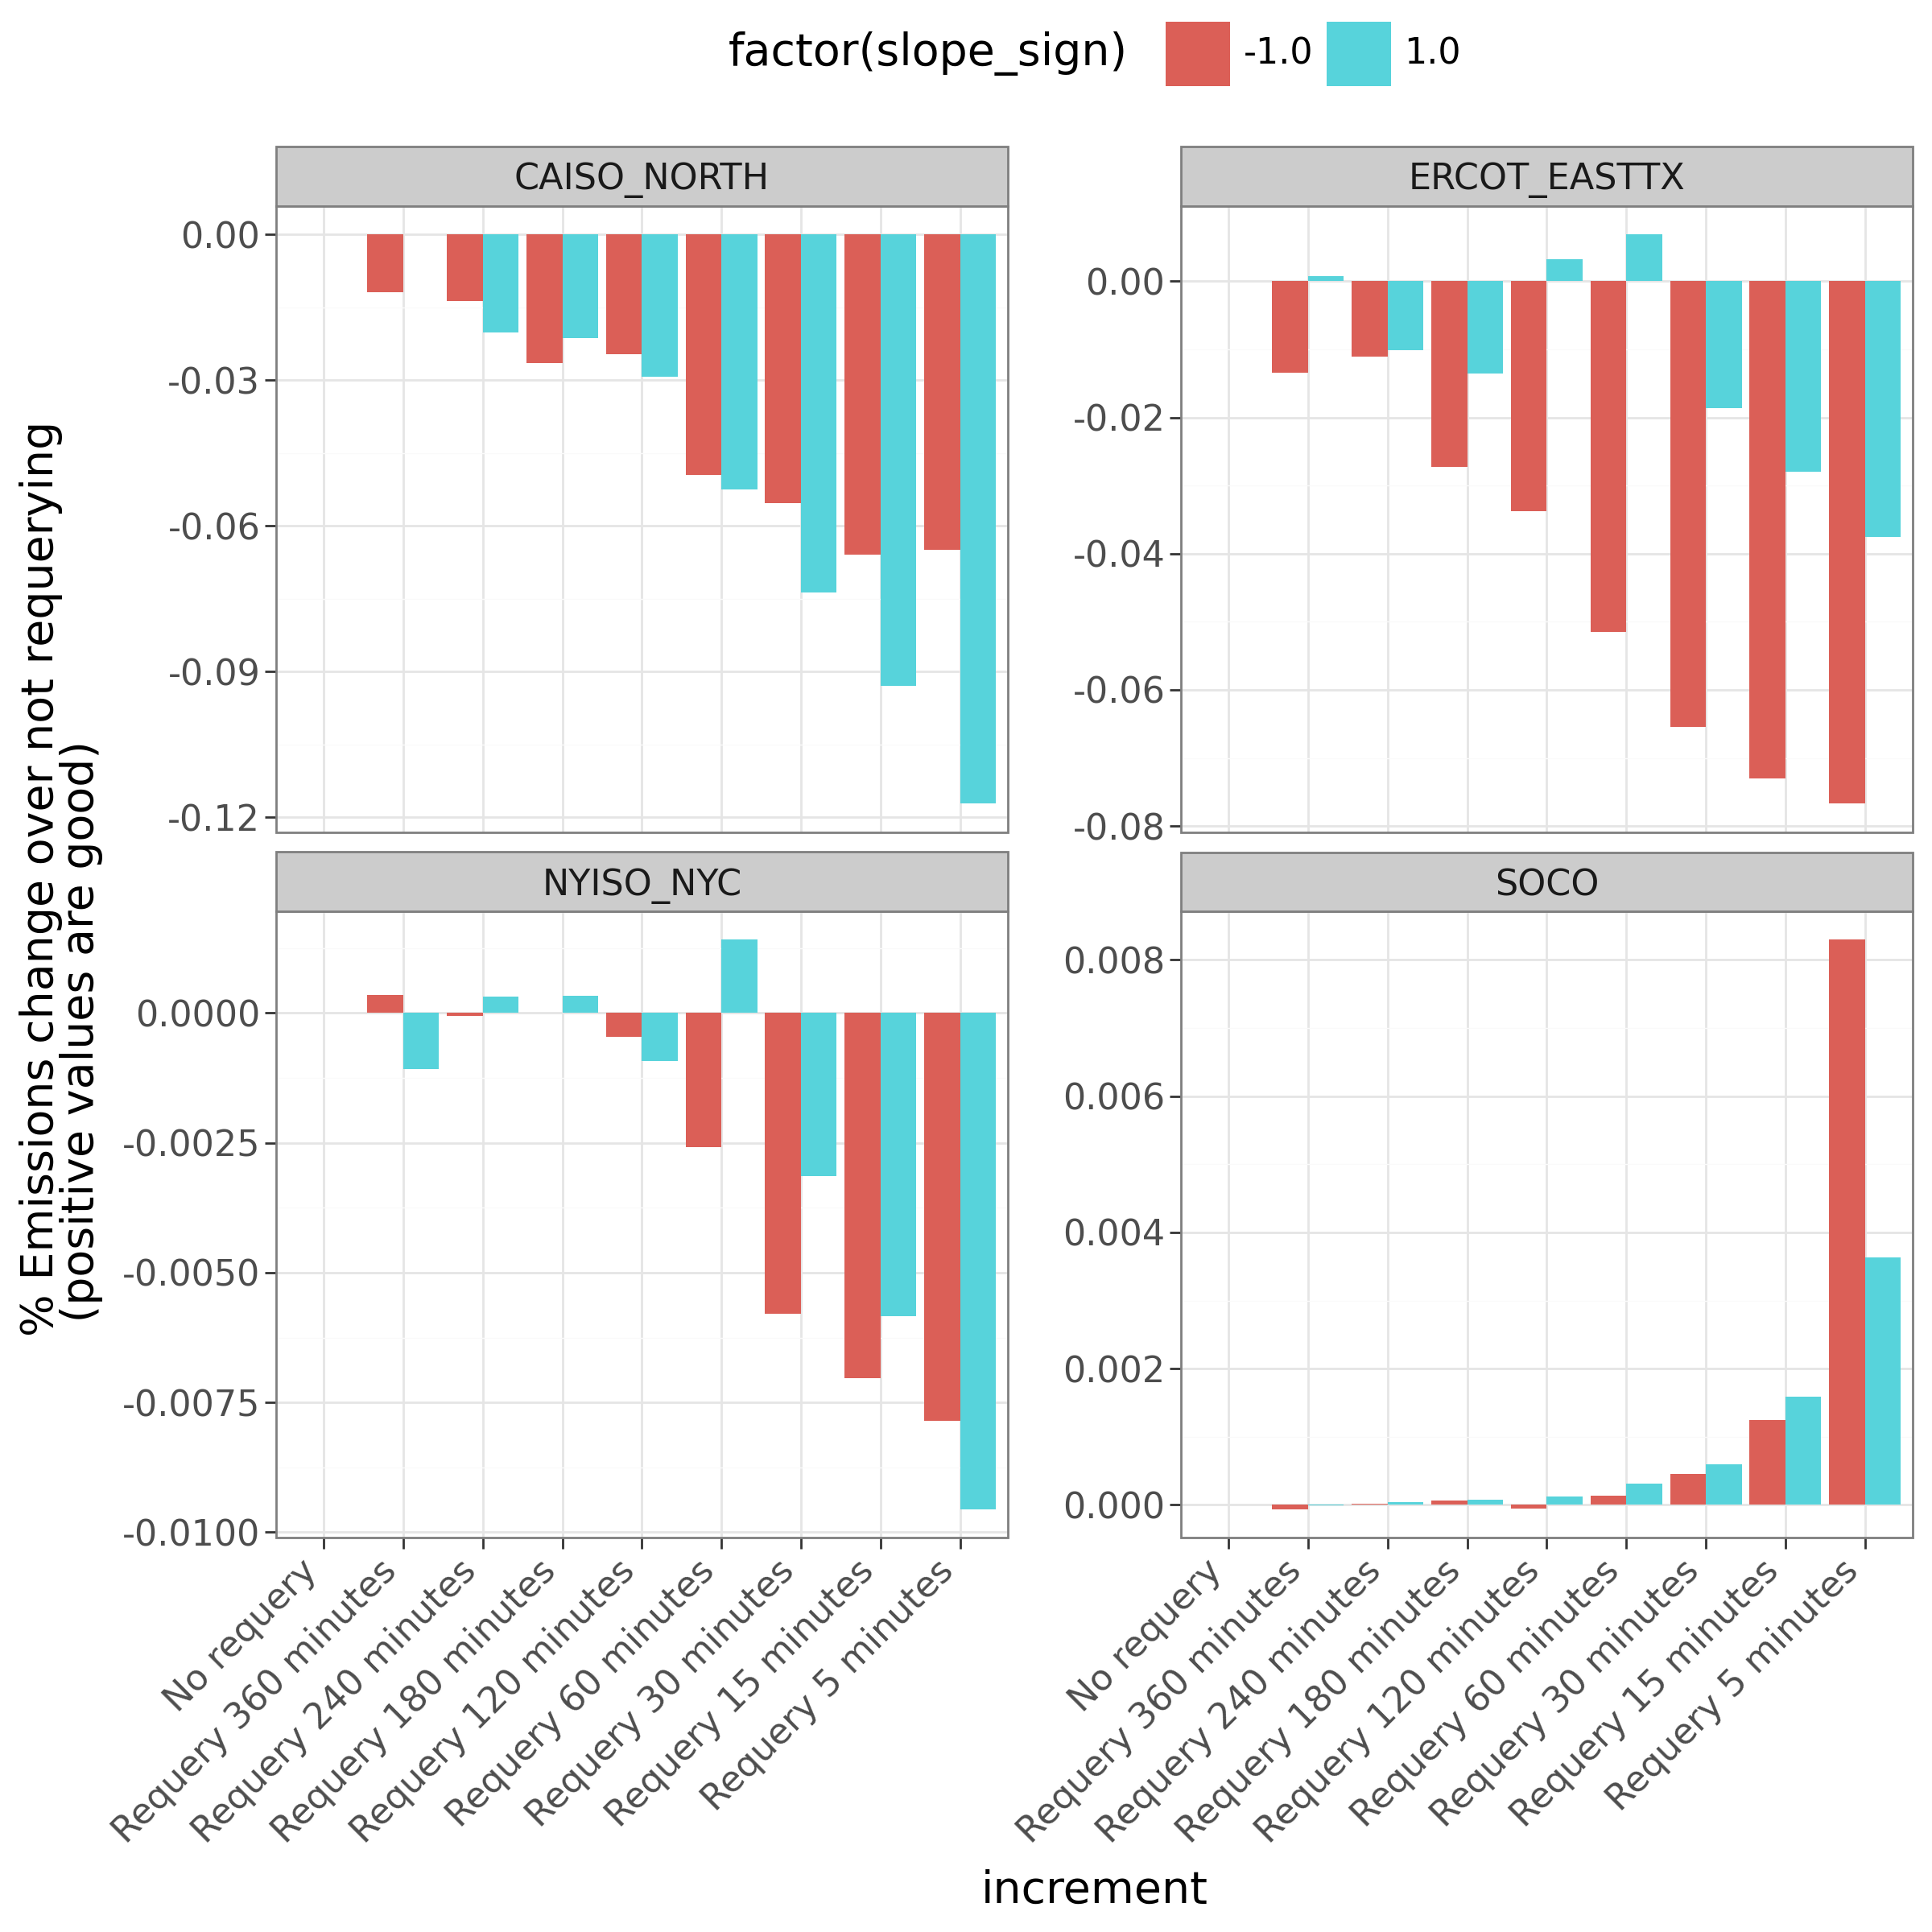

In [ ]:
(ggplot(plot_dat, aes(x = "increment", y = "no_requery_diff", fill = "factor(slope_sign)")) + geom_bar(stat = "identity", position = "dodge") + facet_wrap("~region", scales = "free_y", nrow = 2) + theme_bw(base_size=20) +
     theme(figure_size=(12, 12),axis_text_x=element_text(angle=45, hjust=1), legend_position = 'top') + labs(y = "% Emissions change over not requerying \n (positive values are good)"))

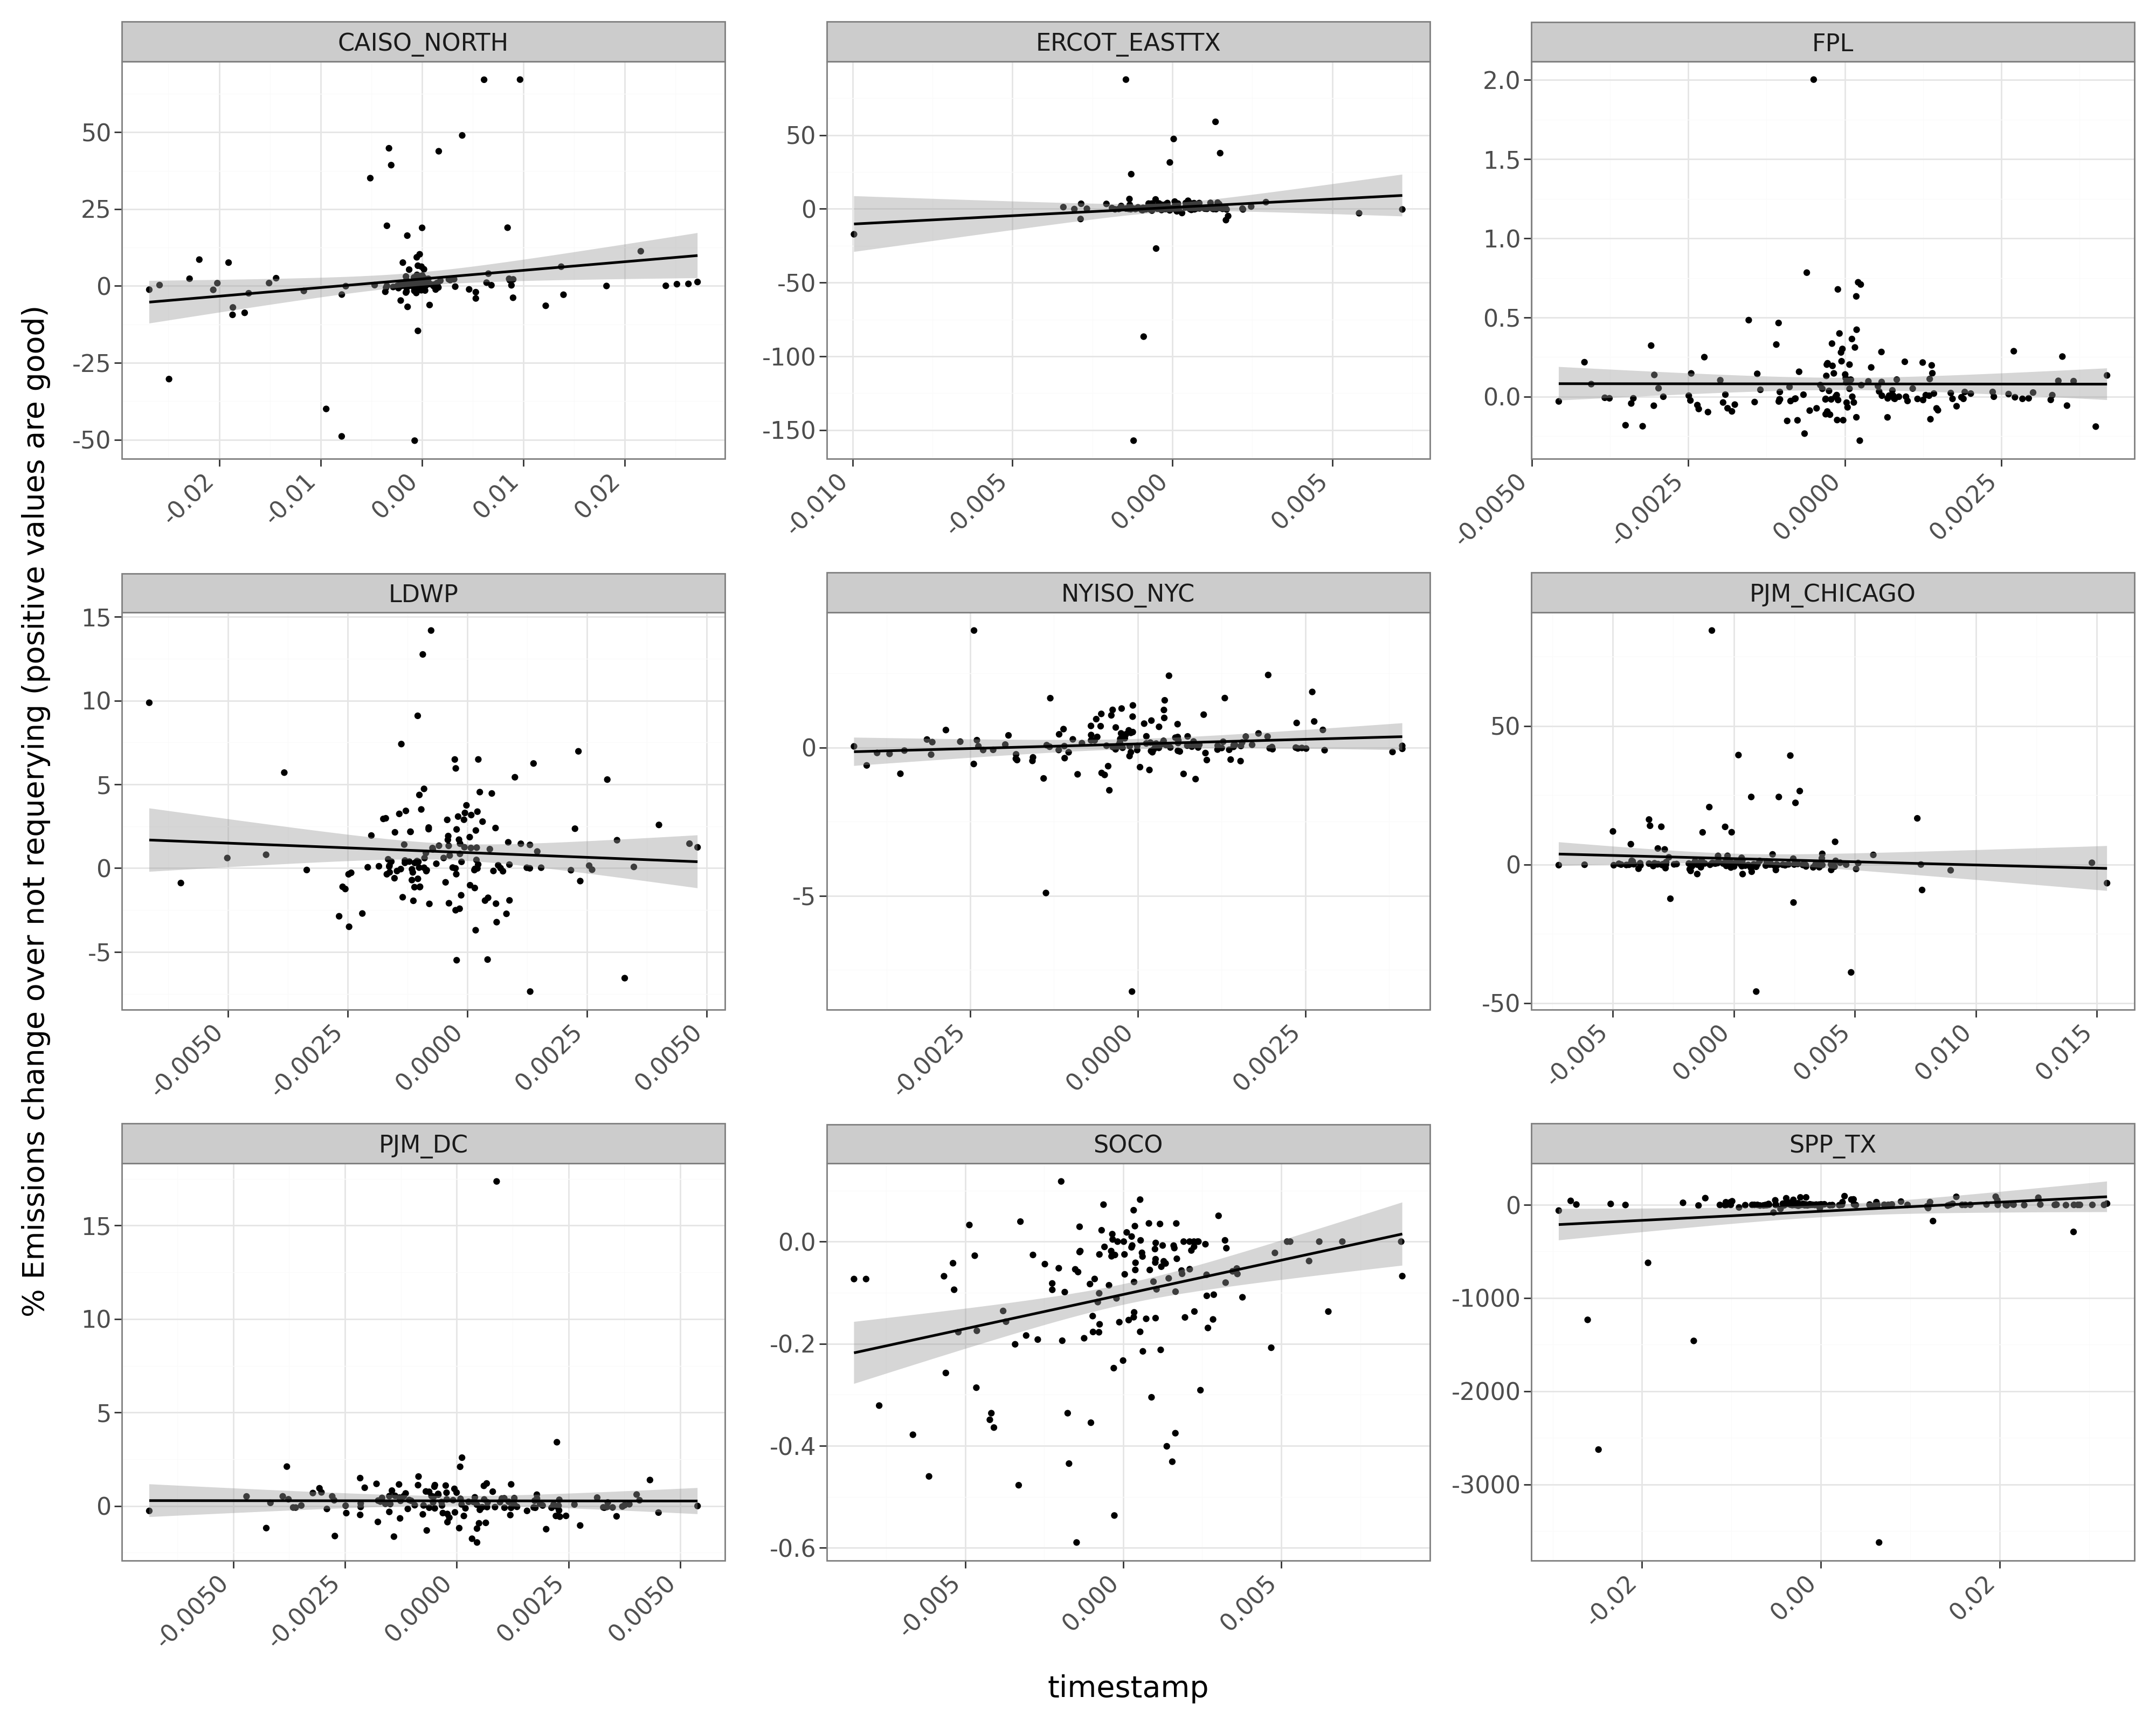

In [ ]:
plot_dat = totals_reg.query("increment == 'Requery 5 minutes'")
(ggplot(plot_dat, aes(x = "timestamp", y = "no_requery_diff_pct")) + geom_point() + geom_smooth(method = "lm") + facet_wrap("~region", scales = "free") + theme_bw(base_size=20) + theme(figure_size=(20, 16),axis_text_x=element_text(angle=45, hjust=1)) + labs(y = "% Emissions change over not requerying (positive values are good)"))

In [ ]:
mod_vars = requery_results.query("increment == 'No requery'")[["point_time", "region", "init_time", "pred_moer"]].groupby(["init_time", "region"]).agg(
    pred_var = ("pred_moer", "mean"),
    pred_min = ("pred_moer", "min"), 
    pred_max = ("pred_moer", "max"), 
).reset_index()

mod_vars["spread"] = abs(mod_vars["pred_min"] - mod_vars["pred_max"])

macs = requery_results.query("increment == 'No requery'").groupby(["init_time", "region"])["pred_moer"].apply(lambda x: x.diff().abs().mean()).reset_index().rename({"pred_moer" : "mac"}, axis = 1)
mod_vars = mod_vars.merge(macs)

In [ ]:
mod_dat = mod_vars.merge(totals_reg.query("increment == 'Requery 15 minutes'"))

In [ ]:
mod_dat

init_time        region     pred_var  pred_min  pred_max  \
0    2023-01-03 14:18:23+00:00   CAISO_NORTH   960.375862     899.4    1001.7   
1    2023-01-03 14:18:23+00:00  ERCOT_EASTTX  1121.031724     945.8    1240.6   
2    2023-01-03 14:18:23+00:00           FPL   837.397241     815.2     866.0   
3    2023-01-03 14:18:23+00:00          LDWP  1183.441379    1158.0    1219.7   
4    2023-01-03 14:18:23+00:00     NYISO_NYC   928.798621     880.3     982.6   
...                        ...           ...          ...       ...       ...   
1344 2023-12-30 18:36:42+00:00     NYISO_NYC   889.531724     854.3     938.3   
1345 2023-12-30 18:36:42+00:00   PJM_CHICAGO  1169.485517    1101.6    1222.0   
1346 2023-12-30 18:36:42+00:00        PJM_DC  1196.912414    1167.3    1230.4   
1347 2023-12-30 18:36:42+00:00          SOCO  1176.731034    1102.2    1204.1   
1348 2023-12-30 18:36:42+00:00        SPP_TX  1183.973103     916.0    1413.7   

      spread        mac  timestamp           increment  actual_emissions  ...  \
0      102.3   2.763889   0.000124  Requery 15 minutes          6.067000  ...   
1      294.8  10.761806   0.001193  Requery 15 minutes          6.829167  ...   
2       50.8   2.415972   0.000255  Requery 15 minutes          4.921000  ...   
3       61.7   2.511111  -0.000990  Requery 15 minutes          7.285833  ...   
4      102.3   3.279167  -0.000265  Requery 15 minutes          5.451833  ...   
...      ...        ...        ...                 ...               ...  ...   
1344    84.0   1.334722  -0.000695  Requery 15 minutes          5.094667  ...   
1345   120.4   8.381250  -0.002928  Requery 15 minutes          7.174000  ...   
1346    63.1   3.092361  -0.001021  Requery 15 minutes          7.163500  ...   
1347   101.9   6.827083   0.001165  Requery 15 minutes          6.731200  ...   
1348   497.7  12.980556  -0.007438  Requery 15 minutes          8.930667  ...   

      ideal_emissions  baseline_emissions  no_requery_emissions  \
0            5.968167            6.009833              5.999333   
1            6.794000            7.141500              7.102667   
2            4.896167            4.933000              4.938833   
3            7.136000            7.232333              7.191167   
4            5.413333            5.832167              5.475333   
...               ...                 ...                   ...   
1344         5.023833            5.278000              5.095500   
1345         7.103500            7.358667              7.187500   
1346         7.103500            7.358667              7.184500   
1347         6.600167            6.654667              6.748483   
1348         8.576167            8.866167              8.926167   

      ideal_diff_pct  baseline_diff_pct  ideal_diff  baseline_diff  \
0           1.656008          -0.951219    0.098833      -0.057167   
1           0.517614           4.373498    0.035167       0.312333   
2           0.507200           0.243260    0.024833       0.012000   
3           2.099682          -0.739734    0.149833      -0.053500   
4           0.711207           6.521304    0.038500       0.380333   
...              ...                ...         ...            ...   
1344        1.409946           3.473538    0.070833       0.183333   
1345        0.992469           2.509513    0.070500       0.184667   
1346        0.844654           2.652201    0.060000       0.195167   
1347        1.985303          -1.150070    0.131033      -0.076533   
1348        4.133548          -0.727485    0.354500      -0.064500   

      no_requery_diff_pct  no_requery_diff  slope_sign  
0               -1.127903         0.067667         1.0  
1                3.850666        -0.273500         1.0  
2                0.361084        -0.017833         1.0  
3               -1.316430         0.094667        -1.0  
4                0.429198        -0.023500        -1.0  
...                   ...              ...         ...  
1344             0.016354     

In [ ]:
import statsmodels.formula.api as smf

regions = [
 'CAISO_NORTH',
 'SPP_TX',
 'ERCOT_EASTTX',
 'FPL',
 'SOCO',
 'PJM_CHICAGO',
 'LDWP',
 'PJM_DC',
 'NYISO_NYC'
]

predictions_df = pd.DataFrame()

for region in regions:
    print("____________________________________________________________________________")
    print(region)
    print("____________________________________________________________________________")
    
    region_data = mod_dat.query("region == @region")    
    model = smf.ols("no_requery_diff_pct ~ mac + timestamp + spread + pred_var", data=region_data).fit()
    print(model.summary())
    
    predictions = model.predict(region_data)
    
    region_predictions = pd.DataFrame({
        'region': region,
        'index': region_data.index,
        'actual_value': region_data['no_requery_diff_pct'],
        'ideal_value': region_data['ideal_diff_pct'],
        'init_time' : region_data['init_time'],
        'predicted_value': predictions
    })

    predictions_df = pd.concat([predictions_df, region_predictions], ignore_index=True)



____________________________________________________________________________
CAISO_NORTH
____________________________________________________________________________
                             OLS Regression Results                            
Dep. Variable:     no_requery_diff_pct   R-squared:                       0.064
Model:                             OLS   Adj. R-squared:                  0.038
Method:                  Least Squares   F-statistic:                     2.469
Date:                 Fri, 25 Oct 2024   Prob (F-statistic):             0.0474
Time:                         05:45:31   Log-Likelihood:                -604.84
No. Observations:                  149   AIC:                             1220.
Df Residuals:                      144   BIC:                             1235.
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                 coef    std err  

In [ ]:
predictions_df.groupby("region").predicted_value.describe()

count       mean         std         min         25%        50%  \
region                                                                          
CAISO_NORTH   149.0   1.989125    3.683340   -8.323658   -0.045457   1.106979   
ERCOT_EASTTX  150.0   0.465310    2.942876  -14.654314   -1.032828   0.426828   
FPL           150.0   0.075025    0.067558   -0.118492    0.034654   0.082720   
LDWP          150.0   0.943440    0.414269   -1.352497    0.712354   0.887755   
NYISO_NYC     150.0   0.065123    0.318003   -0.787897   -0.114378   0.156489   
PJM_CHICAGO   150.0   1.437800    3.024123  -12.846398    0.230428   1.242473   
PJM_DC        150.0   0.225037    0.202532   -0.758824    0.108015   0.245178   
SOCO          150.0  -0.035891    0.038667   -0.299269   -0.042645  -0.027485   
SPP_TX        150.0 -58.861888  106.161741 -381.417105 -100.157188 -17.828000   

                    75%        max  
region                              
CAISO_NORTH    3.999783  15.228811  
ERCOT_EASTTX   1.602845  11.674232  
FPL            0.113771   0.396506  
LDWP           1.155774   2.414730  
NYISO_NYC      0.294014   0.706423  
PJM_CHICAGO    2.563956  11.346772  
PJM_DC         0.372580   0.602541  
SOCO          -0.017463  -0.000085  
SPP_TX        16.493427  55.630314

In [37]:
predictions_df['quantile'] = predictions_df.groupby('region')['predicted_value'].transform(
    lambda x: pd.qcut(x, 3, labels=False, duplicates='drop')
)

In [38]:
predictions_df.groupby(["quantile", "region"]).actual_value.describe()

count        mean         std          min       25%  \
quantile region                                                               
0        CAISO_NORTH    50.0   -0.195054    4.817140   -30.018083 -0.165905   
         ERCOT_EASTTX   50.0   -3.362411   29.613410  -157.142009 -0.175887   
         FPL            50.0    0.030009    0.108257    -0.144849 -0.035044   
         LDWP           50.0    0.681281    2.453779    -5.097110 -0.286493   
         NYISO_NYC      50.0   -0.229285    1.512911    -8.242852 -0.220229   
         PJM_CHICAGO    50.0   -0.663582    7.613121   -46.659055 -0.133520   
         PJM_DC         50.0   -0.136435    0.616861    -1.880038 -0.457799   
         SOCO           50.0   -0.064925    0.132033    -0.589357 -0.087140   
         SPP_TX         50.0 -184.143052  678.513277 -3629.485571 -9.309561   
1        CAISO_NORTH    49.0    1.092784    9.624484   -50.346543  0.088224   
         ERCOT_EASTTX   50.0    1.974708    7.271733    -4.044715  0.133955   
         FPL            50.0    0.037743    0.138394    -0.277369 -0.020567   
         LDWP           50.0    0.981071    2.539965    -5.494430 -0.188389   
         NYISO_NYC      50.0    0.102611    0.440113    -0.800326 -0.058162   
         PJM_CHICAGO    50.0    0.622699    8.989647   -54.136236  0.013033   
         PJM_DC         50.0    0.575460    1.756521    -2.217339 -0.067439   
         SOCO           50.0   -0.029482    0.072100    -0.335818 -0.026274   
         SPP_TX         50.0    7.692625   28.265776   -74.476634 -0.754087   
2        CAISO_NORTH    50.0    5.051718   22.569373   -73.486135 -1.459489   
         ERCOT_EASTTX   50.0    2.783633    8.510616    -6.548857  0.004749   
         FPL            50.0    0.157325    0.360446    -0.347146 -0.009934   
         LDWP           50.0    1.167967    3.754243    -6.566781 -0.349771   
         NYISO_NYC      50.0    0.322044    0.728675    -2.186986  0.010347   
         PJM_CHICAGO    50.0    4.354282   14.634459   -12.381709 -0.459814   
         PJM_DC         50.0    0.236085    0.695374    -1.509442 -0.000556   
         SOCO           50.0   -0.013265    0.044172    -0.153397 -0.033957   
         SPP_TX         50.0   -0.135236   45.377022  -290.120968 -0.966910   

                            50%       75%        max  
quantile region                                       
0        CAISO_NORTH  -0.000000  0.583674  12.945374  
         ERCOT_EASTTX  0.125757  0.900131  87.698258  
         FPL          -0.000000  0.081977   0.322989  
         LDWP          0.249846  1.974710   6.752444  
         NYISO_NYC    -0.031292  0.161043   3.386190  
         PJM_CHICAGO   0.053327  0.404825  13.358608  
         PJM_DC       -0.046554  0.205774   1.189498  
         SOCO         -0.003259 -0.000000   0.256107  
         SPP_TX       -0.246472  4.868561  91.011365  
1        CAISO_NORTH   0.970407  2.922404  19.383466  
         ERCOT_EASTTX  0.878126  1.867690  50.901885  
         FPL          -0.000000  0.071299   0.383522  
         LDWP          0.417569  2.186095   9.065411  
         NYISO_NYC     0.046654  0.257378   1.395334  
         PJM_CHICAGO   0.353041  1.198087  19.489743  
         PJM_DC        0.235358  0.808527  11.128544  
         SOCO         -0.000000 -0.000000   0.054975  
         SPP_TX        0.589320  7.745978  86.398259  
2        CAISO_NORTH   0.336030  3.649563  67.520778  
         ERCOT_EASTTX  0.669294  3.601061  48.900296  
         FPL           0.067005  0.200235   2.208386  
         LDWP          0.163919  1.813229  14.219039  
         NYISO_NYC     0.260249  0.746991   2.270518  
         PJM_CHICAGO   0.275194  3.636647  84.537058  
         PJM_DC        0.224515  0.564935   2.612738  
         SOCO         -0.000000 -0.000000   0.081784  
         SPP_TX        0.048249  1.852649  77.946677

In [39]:
plot_dat = predictions_df.groupby(["quantile", "region"])["actual_value"].median().reset_index()

In [40]:
predictions_df

region  index  actual_value  ideal_value                 init_time  \
0     CAISO_NORTH      0     -1.127903     1.656008 2023-01-03 14:18:23+00:00   
1     CAISO_NORTH      9      2.593290     0.039250 2023-01-03 19:09:40+00:00   
2     CAISO_NORTH     18     -0.028487     2.414980 2023-01-10 07:22:05+00:00   
3     CAISO_NORTH     27      0.845176    10.707588 2023-01-12 15:07:58+00:00   
4     CAISO_NORTH     36     10.308384     0.087695 2023-01-13 01:45:27+00:00   
...           ...    ...           ...          ...                       ...   
1344    NYISO_NYC   1308     -0.194444     0.769828 2023-12-06 11:39:04+00:00   
1345    NYISO_NYC   1317      0.185844     0.318820 2023-12-06 22:07:24+00:00   
1346    NYISO_NYC   1326      0.964434     0.233486 2023-12-25 00:38:13+00:00   
1347    NYISO_NYC   1335      0.249217     0.589619 2023-12-25 12:18:15+00:00   
1348    NYISO_NYC   1344      0.016354     1.409946 2023-12-30 18:36:42+00:00   

      predicted_value  quantile  
0            0.919297         1  
1            0.829119         1  
2            0.690046         1  
3            2.497795         2  
4            1.630870         1  
...               ...       ...  
1344        -0.049798         0  
1345        -0.141355         0  
1346         0.301837         2  
1347         0.267769         2  
1348         0.004831         1  

[1349 rows x 7 columns]

In [41]:
plot_dat

quantile        region  actual_value
0          0   CAISO_NORTH     -0.000000
1          0  ERCOT_EASTTX      0.125757
2          0           FPL     -0.000000
3          0          LDWP      0.249846
4          0     NYISO_NYC     -0.031292
5          0   PJM_CHICAGO      0.053327
6          0        PJM_DC     -0.046554
7          0          SOCO     -0.003259
8          0        SPP_TX     -0.246472
9          1   CAISO_NORTH      0.970407
10         1  ERCOT_EASTTX      0.878126
11         1           FPL     -0.000000
12         1          LDWP      0.417569
13         1     NYISO_NYC      0.046654
14         1   PJM_CHICAGO      0.353041
15         1        PJM_DC      0.235358
16         1          SOCO     -0.000000
17         1        SPP_TX      0.589320
18         2   CAISO_NORTH      0.336030
19         2  ERCOT_EASTTX      0.669294
20         2           FPL      0.067005
21         2          LDWP      0.163919
22         2     NYISO_NYC      0.260249
23         2   PJM_CHICAGO      0.275194
24         2        PJM_DC      0.224515
25         2          SOCO     -0.000000
26         2        SPP_TX      0.048249

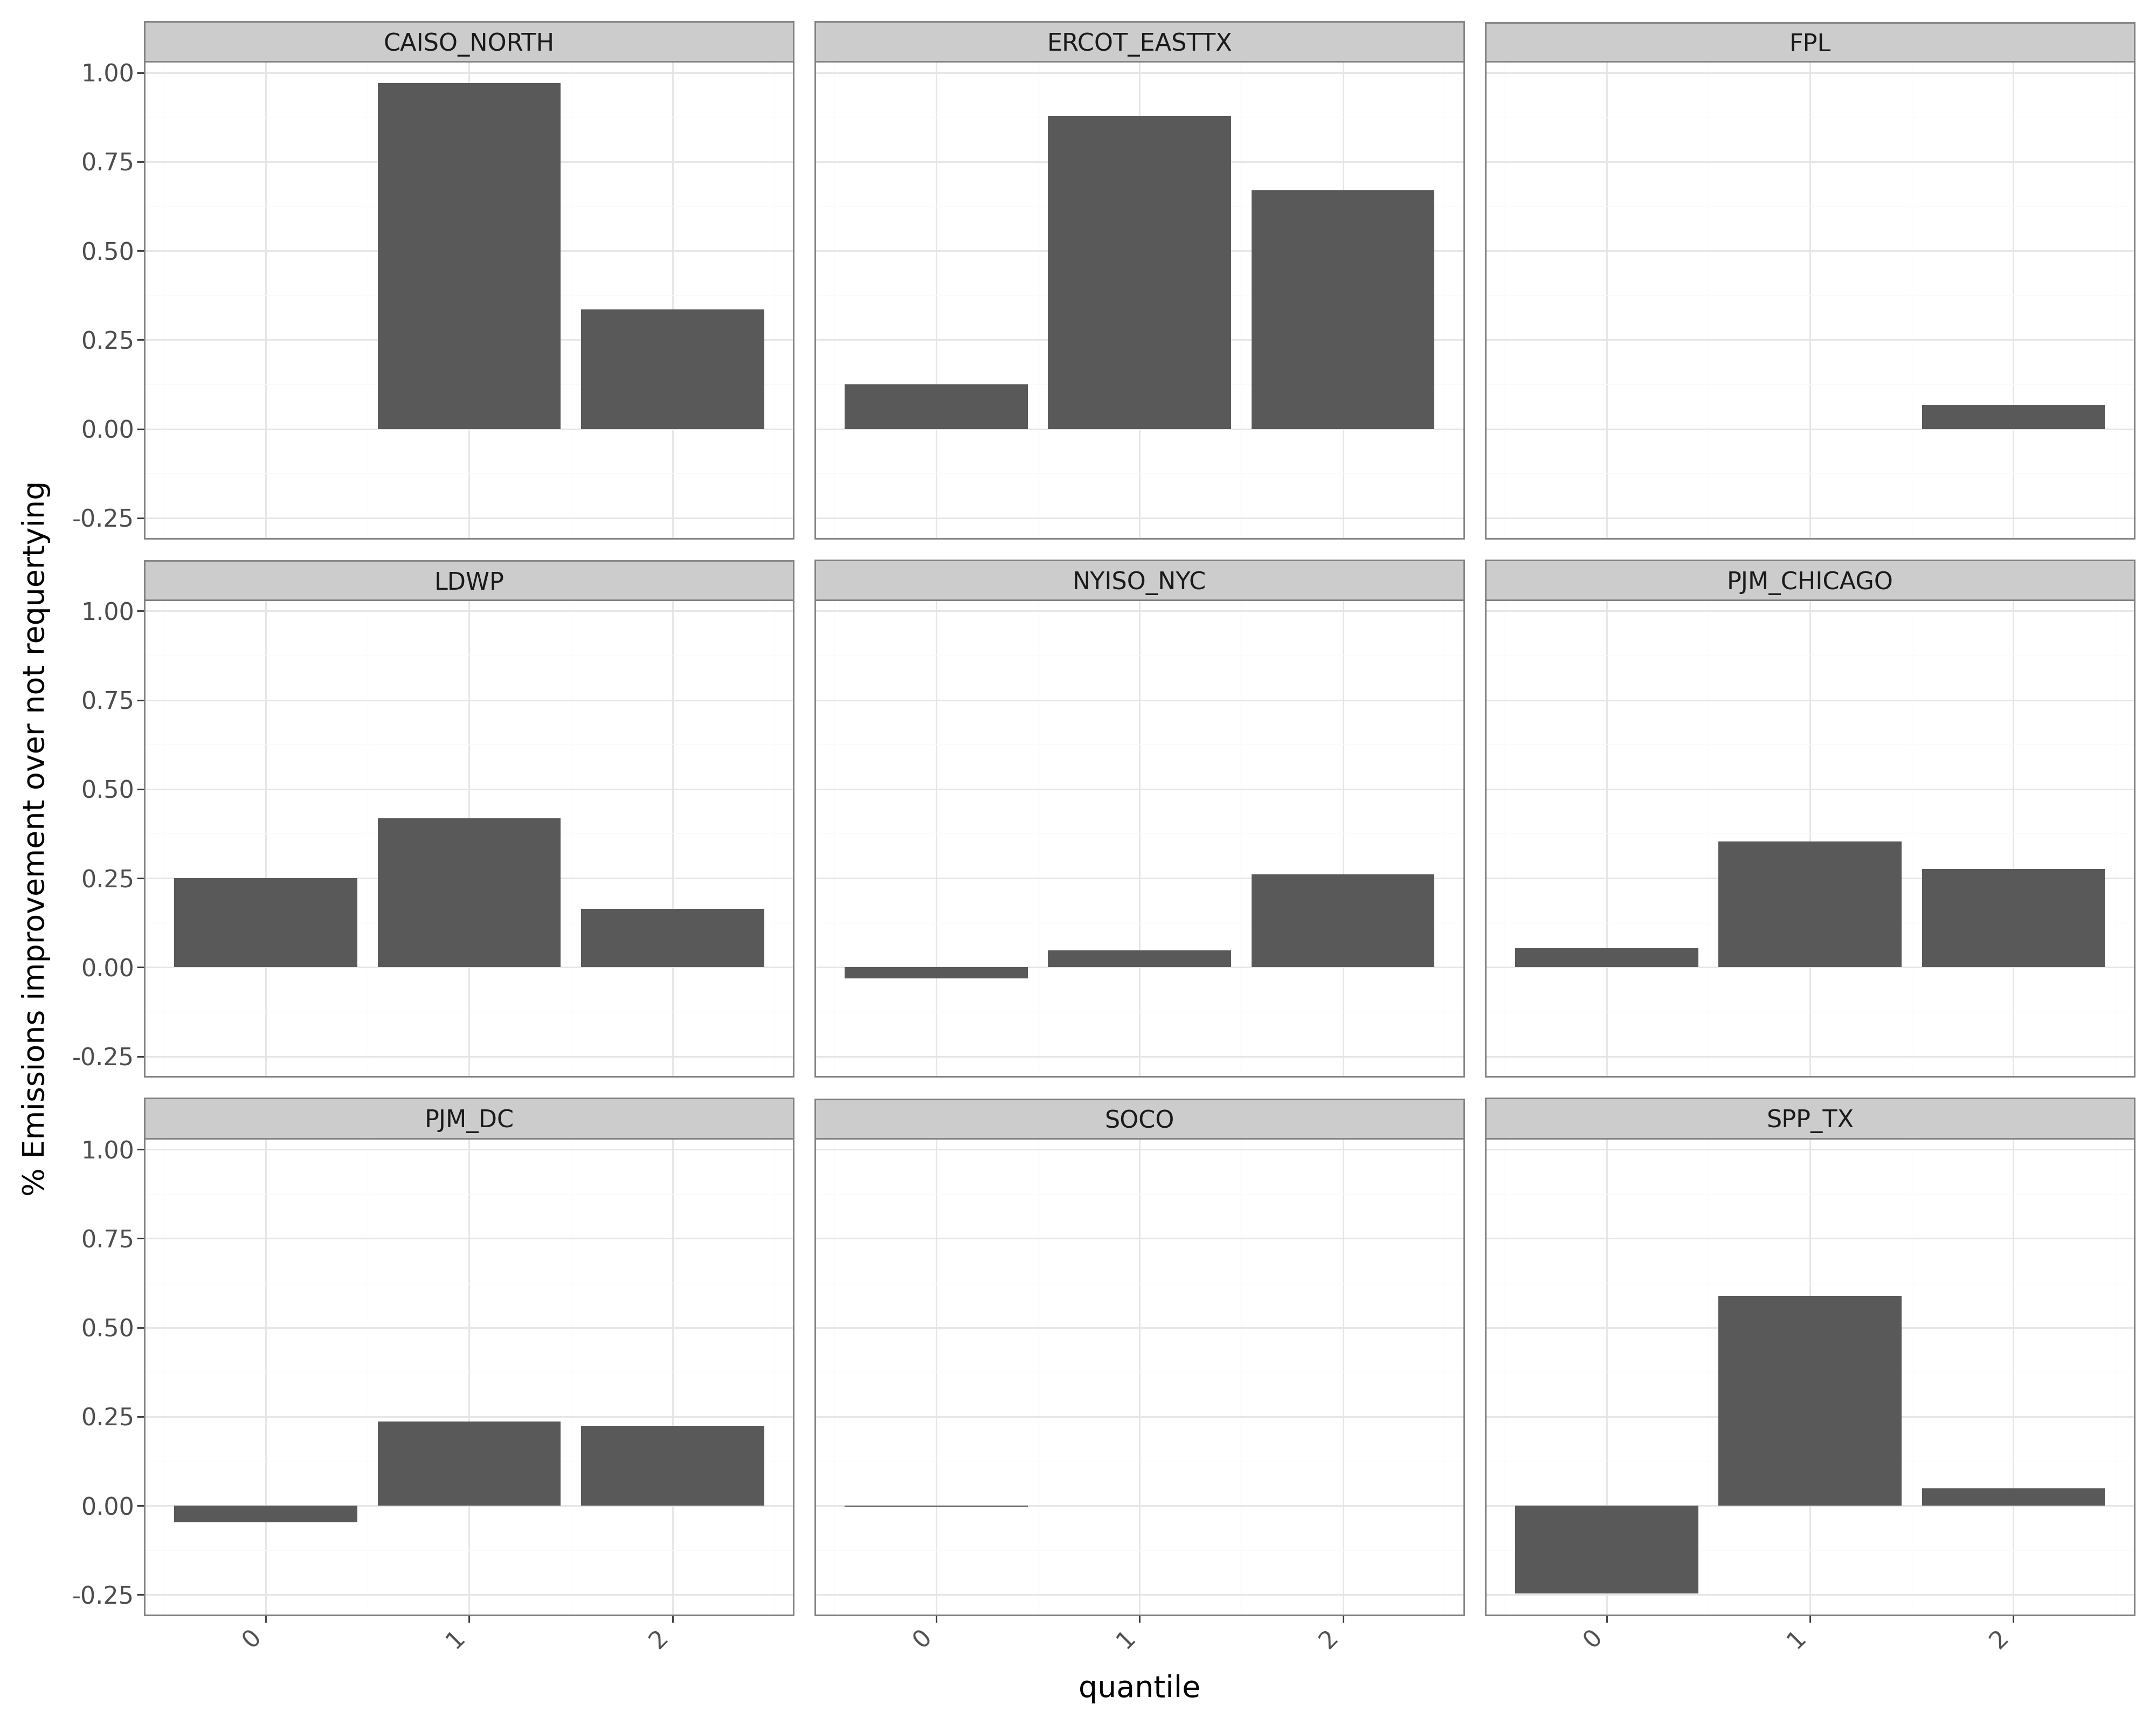

In [42]:
(ggplot(plot_dat, aes(x = "quantile", y = "actual_value")) + geom_bar(stat = "identity") + facet_wrap("~region") + theme_bw(base_size=20) +
     theme(figure_size=(20, 16),axis_text_x=element_text(angle=45, hjust=1)) + labs(y = "% Emissions improvement over not requertying"))

In [43]:
totals_comp

increment       region                 init_time  \
0                  Ideal  CAISO_NORTH 2023-01-03 14:18:23+00:00   
1                  Ideal  CAISO_NORTH 2023-01-03 19:09:40+00:00   
2                  Ideal  CAISO_NORTH 2023-01-10 07:22:05+00:00   
3                  Ideal  CAISO_NORTH 2023-01-12 15:07:58+00:00   
4                  Ideal  CAISO_NORTH 2023-01-13 01:45:27+00:00   
...                  ...          ...                       ...   
14845  Requery 5 minutes       SPP_TX 2023-12-06 11:39:04+00:00   
14846  Requery 5 minutes       SPP_TX 2023-12-06 22:07:24+00:00   
14847  Requery 5 minutes       SPP_TX 2023-12-25 00:38:13+00:00   
14848  Requery 5 minutes       SPP_TX 2023-12-25 12:18:15+00:00   
14849  Requery 5 minutes       SPP_TX 2023-12-30 18:36:42+00:00   

       actual_emissions  emissions_co2e_lb  ideal_emissions  \
0              5.968167           5.968167         5.968167   
1              5.944833           5.944833         5.944833   
2              5.714333           5.714333         5.714333   
3              5.598833           5.598833         5.598833   
4              5.511500           5.511500         5.511500   
...                 ...                ...              ...   
14845          1.287500           0.934633         0.079833   
14846          0.082333           0.311917         0.069833   
14847          0.067667           0.316767         0.066000   
14848          5.050500           2.389217         2.405167   
14849          8.927500           8.667733         8.576167   

       baseline_emissions  no_requery_emissions  ideal_diff_pct  \
0                6.009833              5.999333        0.000000   
1                6.075333              6.105500        0.000000   
2                5.783500              5.850667        0.000000   
3                6.127833              6.251167        0.000000   
4                6.419833              6.150333        0.000000   
...                   ...                   ...             ...   
14845            5.944667              0.096500     1512.734864   
14846            0.082333              0.079833       17.899761   
14847            0.067833              0.068333        2.525253   
14848            4.776000              5.480167      109.985448   
14849            8.866167              8.926167        4.096624   

       baseline_diff_pct  ideal_diff  baseline_diff  no_requery_diff_pct  \
0               0.693308    0.000000       0.041667             0.519502   
1               2.148030    0.000000       0.130500             2.631507   
2               1.195931    0.000000       0.069167             2.330219   
3               8.632741    0.000000       0.529000            10.435385   
4              14.148862    0.000000       0.908333            10.386971   
...                  ...         ...            ...                  ...   
14845          78.341931    1.207667       4.657167         -1234.196891   
14846          -0.000000    0.012500      -0.000000            -3.131524   
14847           0.245700    0.001667       0.000167             0.975610   
14848          -5.747487    2.645333      -0.274500             7.840394   
14849          -0.691768    0.351333      -0.061333            -0.014937   

       no_requery_diff  
0            -0.031167  
1            -0.160667  
2            -0.136333  
3            -0.652333  
4            -0.638833  
...                ...  
14845         1.191000  
14846         0.002500  
14847        -0.000667  
14848        -0.429667  
14849         0.001333  

[14850 rows x 14 columns]

In [1]:
plot_dat = predictions_df.query("quantile == 2").merge(requery_results).merge(totals_comp[["region", "increment", "init_time", "no_requery_diff_pct", "ideal_diff_pct"]]).groupby(["region", "increment"])[["no_requery_diff_pct", "ideal_diff_pct"]].mean().reset_index()
plot_dat

NameError: name 'predictions_df' is not defined

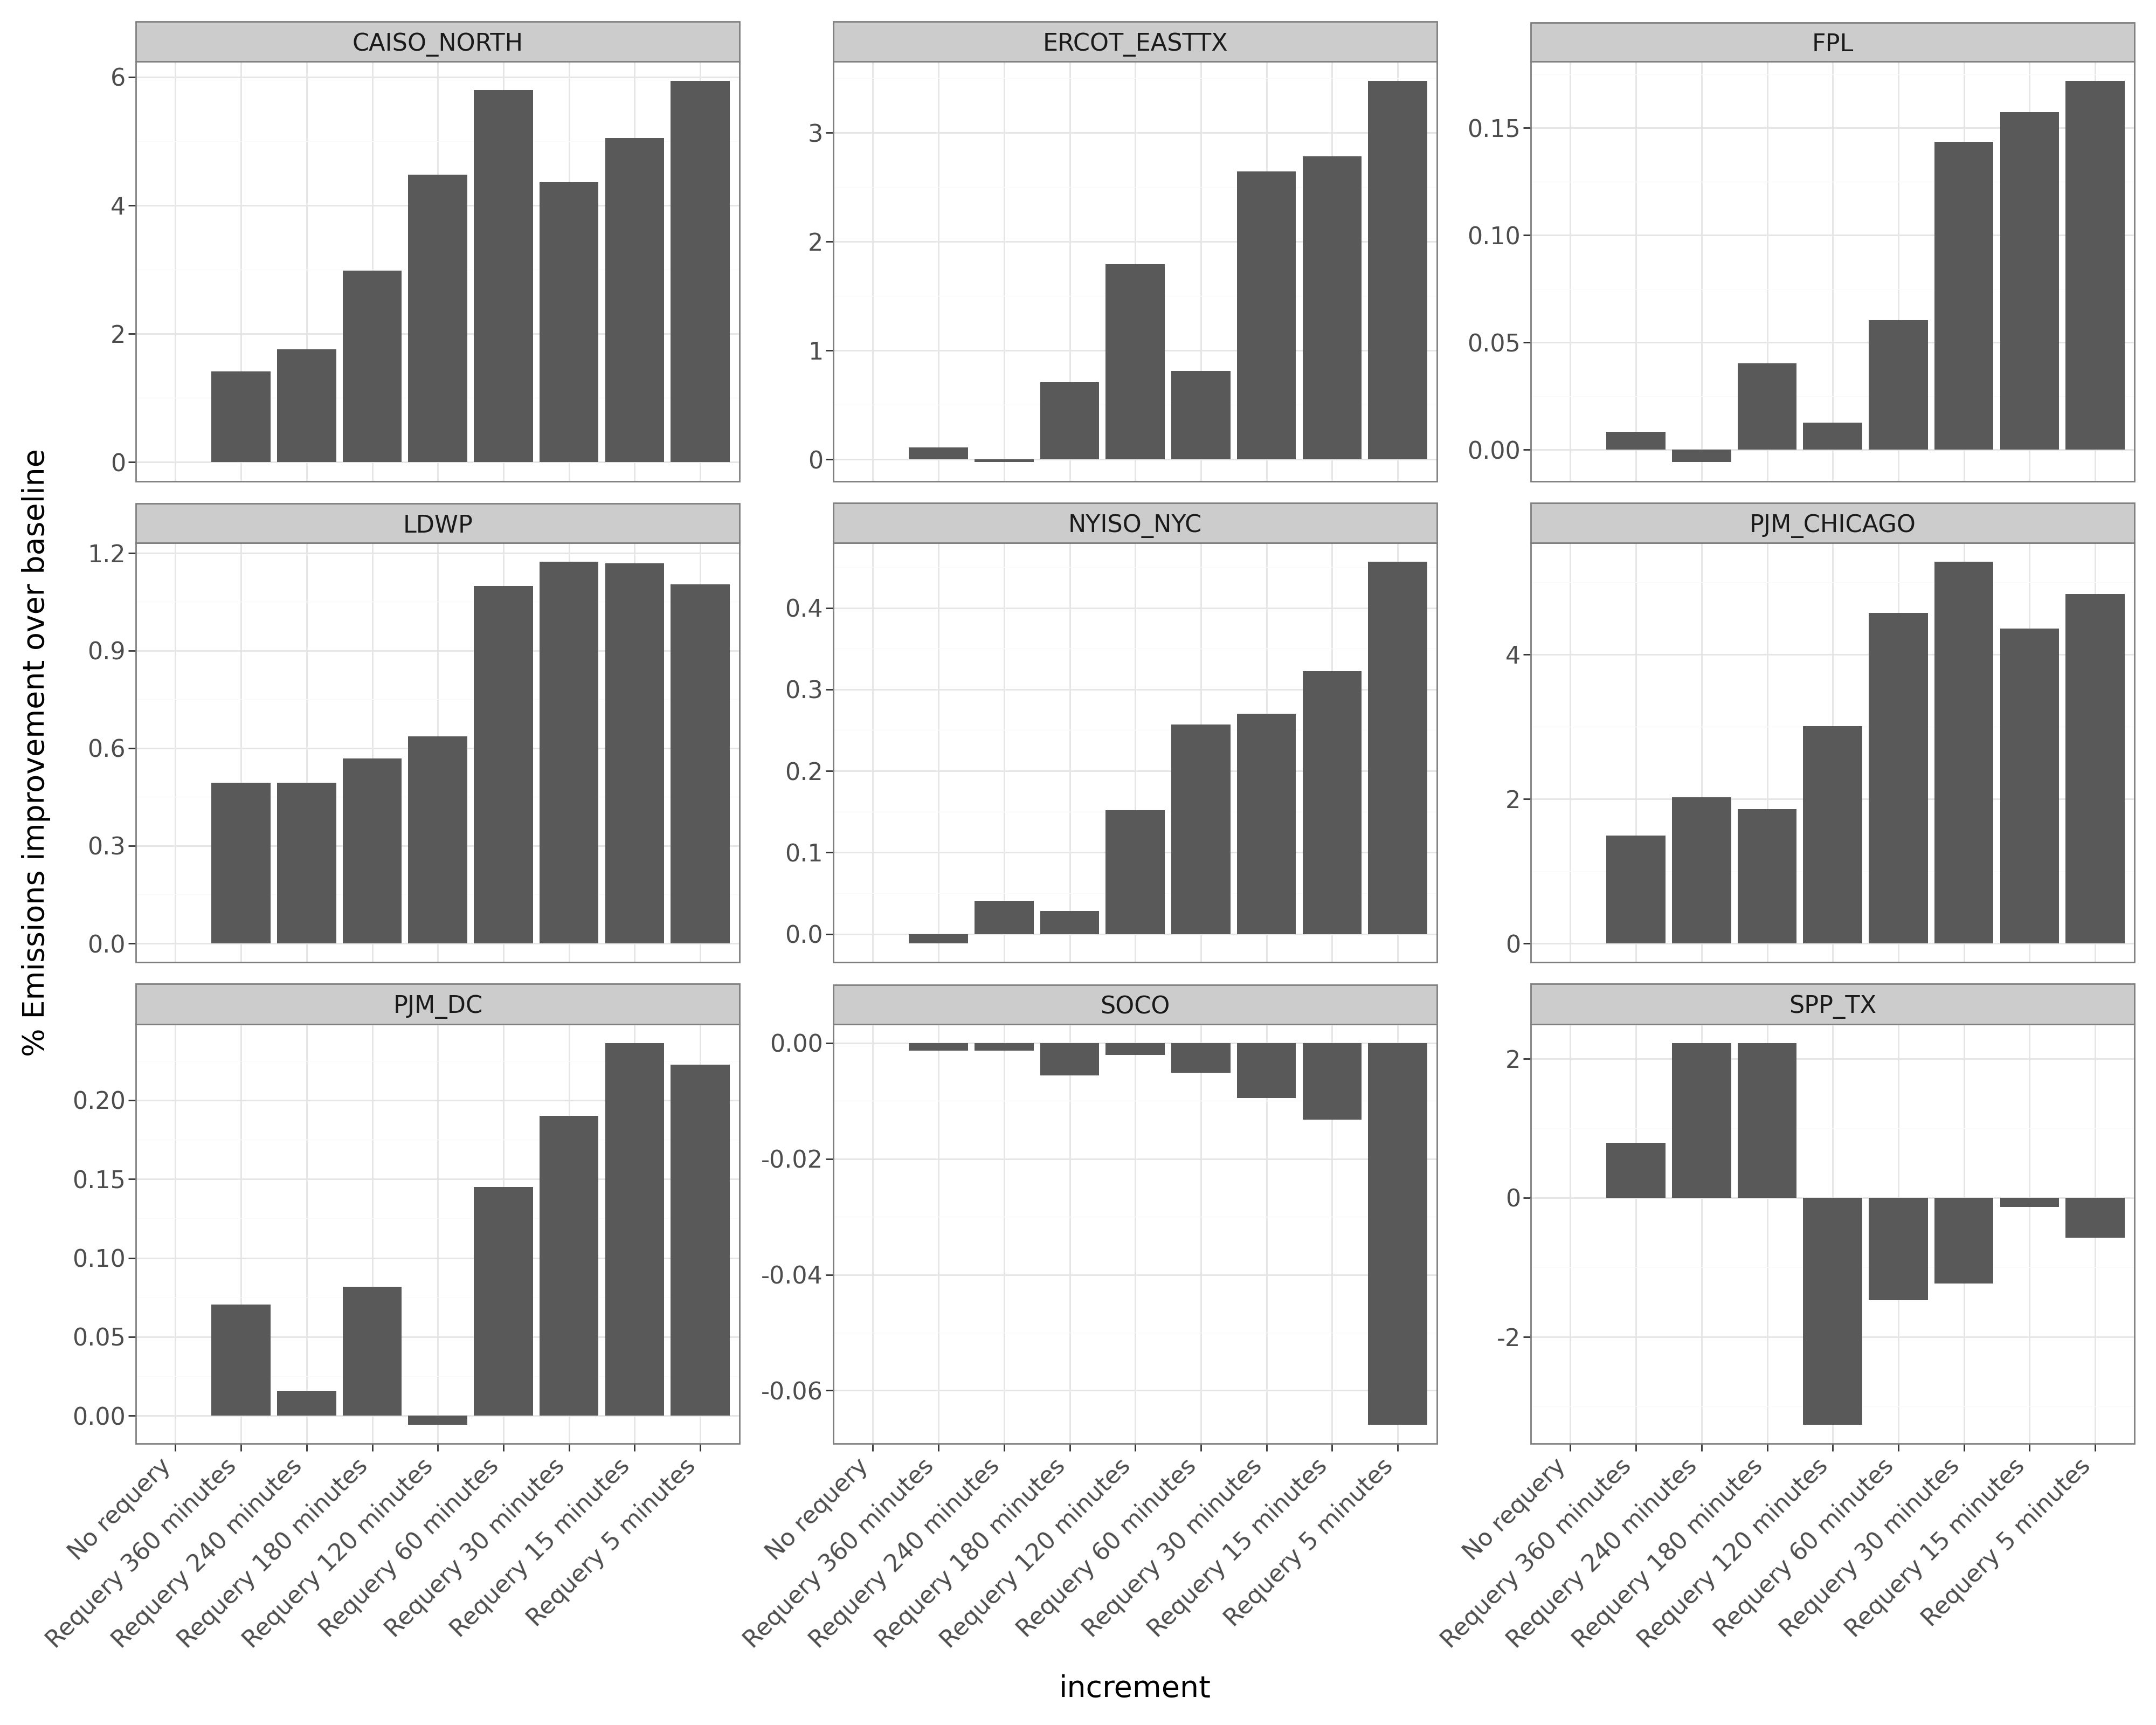

In [48]:
(ggplot(plot_dat.query("~increment.isin(['Baseline', 'Ideal'])"), aes(x = "increment", y = "no_requery_diff_pct")) + geom_bar(stat = "identity") + facet_wrap("~region", scales = "free_y") + theme_bw(base_size=20) +
     theme(figure_size=(20, 16),axis_text_x=element_text(angle=45, hjust=1)) + labs(y = "% Emissions improvement over baseline"))